# Benchmark Newton-LSMR Solver

This notebook benchmarks the GLM solver `newton-lsmr` as proposed in https://github.com/scikit-learn/scikit-learn/pull/25462#.
Several extensions and benchmark tools are added in PR https://github.com/scikit-learn/scikit-learn/pull/26707. So this notebook needs this PR #26707.

The Newton-LSMR solver is special.
It is an inexact Newton solver as it solves the Newton equation $H x = G$ with hessian $H$ and gradient $G$ by an iterative krylov method.
It takes the square root of $H$, say $A$ and solves the equivalend least squares problem $\min ||Ax - b||^2$ with $A'A = H$ and $Ab = -G$.
This is done with the LSMR method for (sparse) least squares.

The choice of the inner stopping criterion is then very crucial and played around later on in this notebook.
For literature, see
- Stephen G. Nash "A survey of truncated-Newton methods" https://doi.org/10.1016/s0377-0427(00)00426-x
- Galli & Lin "A Study on Truncated Newton Methods for Linear Classification"
  - https://www.csie.ntu.edu.tw/~cjlin/papers/tncg/tncg.pdf
  - https://doi.org/10.1109/TNNLS.2020.3045836

## 1. Newton-LSMR vs Other Solvers

Here, the inner solver, i.e. LSMR, is stopped by setting `atol = eta * ||G|| / (||A|| * ||r||)` and `eta = min(c0, c1 ||G|| ** c2)` with `c0, c1, c2 = 0.5, 1, 0.5` and `||A||` and `||r||` are taken from the last run of LSMR.

### 1.1 Poisson Regression on freMTPL

In [1]:
import warnings
from pathlib import Path
import numpy as np
from scipy import sparse
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd


def prepare_data():
    df = fetch_openml(data_id=41214, as_frame=True, parser='auto').frame
    df["Frequency"] = df["ClaimNb"] / df["Exposure"]
    log_scale_transformer = make_pipeline(
        FunctionTransformer(np.log, validate=False), StandardScaler()
    )
    linear_model_preprocessor = ColumnTransformer(
        [
            ("passthrough_numeric", "passthrough", ["BonusMalus"]),
            (
                "binned_numeric",
                KBinsDiscretizer(n_bins=10, subsample=None),
                ["VehAge", "DrivAge"],
            ),
            ("log_scaled_numeric", log_scale_transformer, ["Density"]),
            (
                "onehot_categorical",
                OneHotEncoder(),
                ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
            ),
        ],
        remainder="drop",
    )
    y = df["Frequency"]
    w = df["Exposure"]
    X = linear_model_preprocessor.fit_transform(df)
    return X, np.asarray(y), np.asarray(w)


X, y, w = prepare_data()
#X = X.toarray()
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, train_size=0.8, test_size=0.1, random_state=0
)
print(f"{X_train.shape = }")
print(f"{sparse.issparse(X_train)=}")

results = []
loss_sw = w_train / w_train.sum()
slow_solvers = set()
for tol in np.logspace(-1, -11, 11):
    for solver in ["lbfgs", "newton-cholesky", "newton-lsmr"]:
        if solver in slow_solvers:
            # skip slow solvers to keep the benchmark runtime reasonable
            continue
        tic = perf_counter()
        # with warnings.catch_warnings():
        #     warnings.filterwarnings("ignore", category=ConvergenceWarning)
        reg = PoissonRegressor(
            alpha=1e-12,
            solver=solver,
            tol=tol,
            max_iter=10_000 if solver=="lbfgs" else 100,
        ).fit(X_train, y_train, sample_weight=w_train)
        toc = perf_counter()
        train_time = toc - tic
        n_iter = reg.n_iter_
        if train_time > 200 or n_iter >= reg.max_iter:
            # skip this solver from now on...
            slow_solvers.add(solver)
        # Look inside _GeneralizedLinearRegressor to check the parameters.
        # Or run once with verbose=1 and compare to the reported loss.
        train_loss = LinearModelLoss(
            base_loss=reg._get_loss(), fit_intercept=reg.fit_intercept
        ).loss(
            coef=np.r_[reg.coef_, reg.intercept_],
            X=X_train,
            y=y_train,
            l2_reg_strength=reg.alpha,
            sample_weight=loss_sw,
        )
        result = {
            "solver": solver,
            "tol": tol,
            "train_loss": train_loss,
            "train_time": train_time,
            "train_score": reg.score(X_train, y_train),
            "test_score": reg.score(X_test, y_test),
            "n_iter": n_iter,
            "converged": n_iter < reg.max_iter,
        }
        print(result)
        results.append(result)


results = pd.DataFrame.from_records(results)
filepath = Path().resolve() / "bench_poisson_regression_mtpl.csv"
results.to_csv(filepath)

X_train.shape = (542410, 75)
sparse.issparse(X_train)=True
{'solver': 'lbfgs', 'tol': 0.1, 'train_loss': 0.3328464306664338, 'train_time': 0.1568592080000002, 'train_score': -0.06578227523845315, 'test_score': -0.0629014036983826, 'n_iter': 1, 'converged': True}
{'solver': 'newton-cholesky', 'tol': 0.1, 'train_loss': 0.31729094111807243, 'train_time': 1.794933960999999, 'train_score': 0.011880078358725843, 'test_score': 0.014101632590573732, 'n_iter': 4, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 0.1, 'train_loss': 0.33284730619356984, 'train_time': 0.10990394800000125, 'train_score': -0.06493987325911132, 'test_score': -0.0621002203614911, 'n_iter': 1, 'converged': True}
{'solver': 'lbfgs', 'tol': 0.01, 'train_loss': 0.32086273935645043, 'train_time': 0.5748236700000007, 'train_score': -0.0076780417274056045, 'test_score': -0.003056226093261838, 'n_iter': 26, 'converged': True}
{'solver': 'newton-cholesky', 'tol': 0.01, 'train_loss': 0.31729094111807243, 'train_time': 1.79361

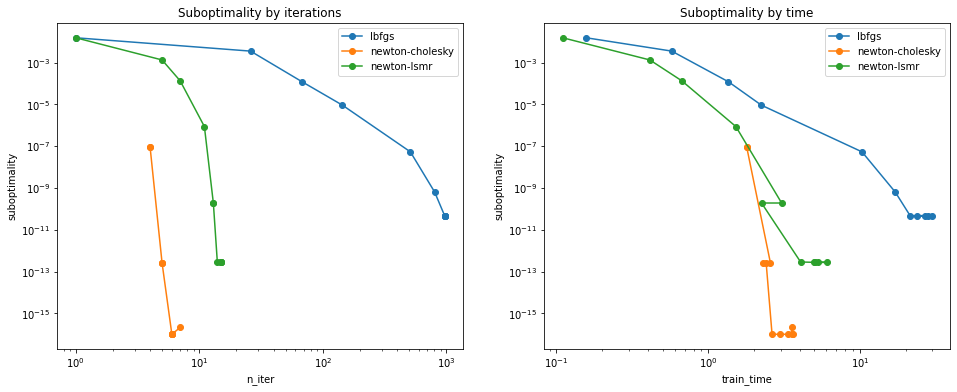

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


filepath = Path().resolve() / "bench_poisson_regression_mtpl.csv"

results = pd.read_csv(filepath)
results["suboptimality"] = results["train_loss"] - results["train_loss"].min() + 1e-16

fig, axes = plt.subplots(ncols=2, figsize=(8*2, 6))
for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(
        x="n_iter", y="suboptimality", loglog=True, marker="o", label=label, ax=axes[0]
    )
axes[0].set_ylabel("suboptimality")
axes[0].set_title("Suboptimality by iterations")

for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(
        x="train_time", y="suboptimality", loglog=True, marker="o", label=label, ax=axes[1]
    )
axes[1].set_ylabel("suboptimality")
axes[1].set_title("Suboptimality by time")
plt.show()

In [3]:
%%time
PoissonRegressor(
    alpha=1e-12, solver="newton-lsmr", tol=1e-10
).fit(X_train, y_train, sample_weight=w_train)

CPU times: user 15 s, sys: 5.24 s, total: 20.3 s
Wall time: 5.36 s


PoissonRegressor(alpha=1e-12, solver='newton-lsmr', tol=1e-10)

In [4]:
results["train_loss"].min()

0.3172908518762614

### 1.2. Multinomial Logistic Regression on freMTPL
#### Sparse

In [3]:
import warnings
from pathlib import Path
import numpy as np
from scipy import sparse
from sklearn._loss import HalfMultinomialLoss
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd



def prepare_data():
    df = fetch_openml(data_id=41214, as_frame=True, parser='auto').frame
    df["Frequency"] = df["ClaimNb"] / df["Exposure"]
    log_scale_transformer = make_pipeline(
        FunctionTransformer(np.log, validate=False), StandardScaler()
    )
    linear_model_preprocessor = ColumnTransformer(
        [
            ("passthrough_numeric", "passthrough", ["BonusMalus"]),
            (
                "binned_numeric",
                KBinsDiscretizer(n_bins=10, subsample=None),
                ["VehAge", "DrivAge"],
            ),
            ("log_scaled_numeric", log_scale_transformer, ["Density"]),
            (
                "onehot_categorical",
                OneHotEncoder(),
                ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
            ),
        ],
        remainder="drop",
    )
    y = df["Frequency"]
    w = df["Exposure"]
    X = linear_model_preprocessor.fit_transform(df)
    return X, y, w


X, y_orig, w = prepare_data()

print("binning the target...")
binner = KBinsDiscretizer(
    n_bins=300, encode="ordinal", strategy="quantile", subsample=int(2e5), random_state=0
)
y = binner.fit_transform(y_orig.to_numpy().reshape(-1, 1)).ravel().astype(float)

# X = X.toarray()
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, train_size=10_000, test_size=10_000, random_state=0
)
print(f"{X_train.shape = }")
print(f"{sparse.issparse(X_train)=}")
n_classes = len(np.unique(y_train))
print(f"{n_classes=}")
print("y_train.value_counts() :")
print(pd.Series(y_train).value_counts())


results = []
slow_solvers = set()
loss_sw = np.full_like(y_train, fill_value=(1. / y_train.shape[0]))
alpha = 1e-12
for tol in np.logspace(-1, -10, 10):
    for solver in ["lbfgs", "newton-cg", "newton-lsmr"]:
        if solver in slow_solvers:
            # skip slow solvers to keep the benchmark runtime reasonable
            continue
        tic = perf_counter()
        # with warnings.catch_warnings():
        #     warnings.filterwarnings("ignore", category=ConvergenceWarning)
        clf = LogisticRegression(
            C=1/alpha,
            solver=solver,
            tol=tol,
            max_iter=10_000 if solver=="lbfgs" else 1000,
        ).fit(X_train, y_train)
        toc = perf_counter()
        train_time = toc - tic
        n_iter = clf.n_iter_[0]
        if train_time > 200 or n_iter >= clf.max_iter:
            # skip this solver from now on...
            slow_solvers.add(solver)
        # Look inside _GeneralizedLinearRegressor to check the parameters.
        # Or run once with verbose=1 and compare to the reported loss.
        train_loss = LinearModelLoss(
            base_loss=HalfMultinomialLoss(n_classes=n_classes), fit_intercept=clf.fit_intercept
        ).loss(
            coef=np.c_[clf.coef_, clf.intercept_],
            X=X_train,
            y=y_train,
            l2_reg_strength=alpha / X_train.shape[0],
            sample_weight=loss_sw,
        )
        result = {
            "solver": solver,
            "tol": tol,
            "train_loss": train_loss,
            "train_time": train_time,
            "train_score": clf.score(X_train, y_train),
            "test_score": clf.score(X_test, y_test),
            "n_iter": n_iter,
            "converged": n_iter < clf.max_iter,
        }
        print(result)
        results.append(result)


results = pd.DataFrame.from_records(results)
filepath = Path().resolve() / "bench_multinomial_logistic_regression_mtpl_sparse.csv"
results.to_csv(filepath)

binning the target...
X_train.shape = (10000, 75)
sparse.issparse(X_train)=True
n_classes=12
y_train.value_counts() :
0.0     9501
1.0      156
3.0       45
11.0      41
5.0       38
9.0       36
4.0       35
10.0      34
2.0       31
6.0       29
8.0       28
7.0       26
dtype: int64


/Users/lorentzen/github/scikit-learn/sklearn/preprocessing/_discretization.py:312: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


{'solver': 'lbfgs', 'tol': 0.1, 'train_loss': 0.2533166034610266, 'train_time': 12.424285390000009, 'train_score': 0.95, 'test_score': 0.9521, 'n_iter': 4857, 'converged': True}
{'solver': 'newton-cg', 'tol': 0.1, 'train_loss': 0.2532865013399421, 'train_time': 2.866303153000004, 'train_score': 0.95, 'test_score': 0.9521, 'n_iter': 54, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 0.1, 'train_loss': 0.3530106394739861, 'train_time': 0.10084042299999396, 'train_score': 0.9501, 'test_score': 0.9523, 'n_iter': 5, 'converged': True}
{'solver': 'lbfgs', 'tol': 0.01, 'train_loss': 0.2533166034610266, 'train_time': 14.699120011000005, 'train_score': 0.95, 'test_score': 0.9521, 'n_iter': 4857, 'converged': True}
{'solver': 'newton-cg', 'tol': 0.01, 'train_loss': 0.25325742007284324, 'train_time': 8.128916214, 'train_score': 0.95, 'test_score': 0.952, 'n_iter': 81, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 0.01, 'train_loss': 0.2791565672828294, 'train_time': 0.3739820969999812,

/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


{'solver': 'newton-cg', 'tol': 1e-05, 'train_loss': 0.25325295701145983, 'train_time': 199.85701057200004, 'train_score': 0.95, 'test_score': 0.952, 'n_iter': 1000, 'converged': False}
{'solver': 'newton-lsmr', 'tol': 1e-05, 'train_loss': 0.2533087451792428, 'train_time': 3.6252155280000125, 'train_score': 0.95, 'test_score': 0.952, 'n_iter': 36, 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-06, 'train_loss': 0.2533166034610266, 'train_time': 12.347437652000053, 'train_score': 0.95, 'test_score': 0.9521, 'n_iter': 4857, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-06, 'train_loss': 0.2532626656009668, 'train_time': 6.435234499999979, 'train_score': 0.95, 'test_score': 0.952, 'n_iter': 40, 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-07, 'train_loss': 0.2533166034610266, 'train_time': 12.189115778000087, 'train_score': 0.95, 'test_score': 0.9521, 'n_iter': 4857, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-07, 'train_loss': 0.2532542577827176, 'train_time': 9.

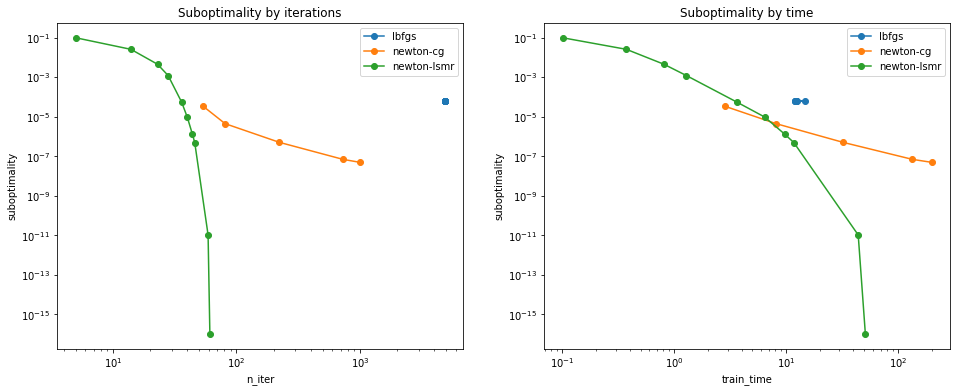

In [4]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


filepath = Path().resolve() / "bench_multinomial_logistic_regression_mtpl_sparse.csv"

results = pd.read_csv(filepath)
results["suboptimality"] = results["train_loss"] - results["train_loss"].min() + 1e-16

fig, axes = plt.subplots(ncols=2, figsize=(8*2, 6))
for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(
        x="n_iter", y="suboptimality", loglog=True, marker="o", label=label, ax=axes[0]
    )
axes[0].set_ylabel("suboptimality")
axes[0].set_title("Suboptimality by iterations")

for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(
        x="train_time", y="suboptimality", loglog=True, marker="o", label=label, ax=axes[1]
    )
axes[1].set_ylabel("suboptimality")
axes[1].set_title("Suboptimality by time")
plt.show()

#### Dense

In [5]:
import warnings
from pathlib import Path
import numpy as np
from scipy import sparse
from sklearn._loss import HalfMultinomialLoss
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd



def prepare_data():
    df = fetch_openml(data_id=41214, as_frame=True, parser='auto').frame
    df["Frequency"] = df["ClaimNb"] / df["Exposure"]
    log_scale_transformer = make_pipeline(
        FunctionTransformer(np.log, validate=False), StandardScaler()
    )
    linear_model_preprocessor = ColumnTransformer(
        [
            ("passthrough_numeric", "passthrough", ["BonusMalus"]),
            (
                "binned_numeric",
                KBinsDiscretizer(n_bins=10, subsample=None),
                ["VehAge", "DrivAge"],
            ),
            ("log_scaled_numeric", log_scale_transformer, ["Density"]),
            (
                "onehot_categorical",
                OneHotEncoder(),
                ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
            ),
        ],
        remainder="drop",
    )
    y = df["Frequency"]
    w = df["Exposure"]
    X = linear_model_preprocessor.fit_transform(df)
    return X, y, w


X, y_orig, w = prepare_data()

print("binning the target...")
binner = KBinsDiscretizer(
    n_bins=300, encode="ordinal", strategy="quantile", subsample=int(2e5), random_state=0
)
y = binner.fit_transform(y_orig.to_numpy().reshape(-1, 1)).ravel().astype(float)

X = X.toarray()
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, train_size=10_000, test_size=10_000, random_state=0
)
print(f"{X_train.shape = }")
print(f"{sparse.issparse(X_train)=}")
n_classes = len(np.unique(y_train))
print(f"{n_classes=}")
print("y_train.value_counts() :")
print(pd.Series(y_train).value_counts())


results = []
slow_solvers = set()
loss_sw = np.full_like(y_train, fill_value=(1. / y_train.shape[0]))
alpha = 1e-12
for tol in np.logspace(-1, -10, 10):
    for solver in ["lbfgs", "newton-cg", "newton-lsmr"]:
        if solver in slow_solvers:
            # skip slow solvers to keep the benchmark runtime reasonable
            continue
        tic = perf_counter()
        # with warnings.catch_warnings():
        #     warnings.filterwarnings("ignore", category=ConvergenceWarning)
        clf = LogisticRegression(
            C=1/alpha,
            solver=solver,
            tol=tol,
            max_iter=10_000 if solver=="lbfgs" else 1000,
        ).fit(X_train, y_train)
        toc = perf_counter()
        train_time = toc - tic
        n_iter = clf.n_iter_[0]
        if train_time > 200 or n_iter >= clf.max_iter:
            # skip this solver from now on...
            slow_solvers.add(solver)
        # Look inside _GeneralizedLinearRegressor to check the parameters.
        # Or run once with verbose=1 and compare to the reported loss.
        train_loss = LinearModelLoss(
            base_loss=HalfMultinomialLoss(n_classes=n_classes), fit_intercept=clf.fit_intercept
        ).loss(
            coef=np.c_[clf.coef_, clf.intercept_],
            X=X_train,
            y=y_train,
            l2_reg_strength=alpha / X_train.shape[0],
            sample_weight=loss_sw,
        )
        result = {
            "solver": solver,
            "tol": tol,
            "train_loss": train_loss,
            "train_time": train_time,
            "train_score": clf.score(X_train, y_train),
            "test_score": clf.score(X_test, y_test),
            "n_iter": n_iter,
            "converged": n_iter < clf.max_iter,
        }
        print(result)
        results.append(result)


results = pd.DataFrame.from_records(results)
filepath = Path().resolve() / "bench_multinomial_logistic_regression_mtpl_dense.csv"
results.to_csv(filepath)

binning the target...


/Users/lorentzen/github/scikit-learn/sklearn/preprocessing/_discretization.py:312: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


X_train.shape = (10000, 75)
sparse.issparse(X_train)=False
n_classes=12
y_train.value_counts() :
0.0     9501
1.0      156
3.0       45
11.0      41
5.0       38
9.0       36
4.0       35
10.0      34
2.0       31
6.0       29
8.0       28
7.0       26
dtype: int64
{'solver': 'lbfgs', 'tol': 0.1, 'train_loss': 0.25340017702232914, 'train_time': 15.46934699499991, 'train_score': 0.95, 'test_score': 0.9521, 'n_iter': 4556, 'converged': True}
{'solver': 'newton-cg', 'tol': 0.1, 'train_loss': 0.2533221591024648, 'train_time': 3.426564138999993, 'train_score': 0.95, 'test_score': 0.9521, 'n_iter': 52, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 0.1, 'train_loss': 0.35301063947398564, 'train_time': 0.09952892399996927, 'train_score': 0.9501, 'test_score': 0.9523, 'n_iter': 5, 'converged': True}
{'solver': 'lbfgs', 'tol': 0.01, 'train_loss': 0.25340017702232914, 'train_time': 15.531023911000034, 'train_score': 0.95, 'test_score': 0.9521, 'n_iter': 4556, 'converged': True}
{'solver': '

/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


{'solver': 'newton-cg', 'tol': 1e-05, 'train_loss': 0.2532529415977771, 'train_time': 304.6518694040001, 'train_score': 0.95, 'test_score': 0.952, 'n_iter': 1000, 'converged': False}
{'solver': 'newton-lsmr', 'tol': 1e-05, 'train_loss': 0.25329657189838384, 'train_time': 3.0790821810001034, 'train_score': 0.95, 'test_score': 0.952, 'n_iter': 38, 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-06, 'train_loss': 0.25340017702232914, 'train_time': 15.455527478000022, 'train_score': 0.95, 'test_score': 0.9521, 'n_iter': 4556, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-06, 'train_loss': 0.25327232949016676, 'train_time': 3.765228147000016, 'train_score': 0.95, 'test_score': 0.952, 'n_iter': 40, 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-07, 'train_loss': 0.25340017702232914, 'train_time': 15.800213888000144, 'train_score': 0.95, 'test_score': 0.9521, 'n_iter': 4556, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-07, 'train_loss': 0.2532556110780084, 'train_time': 

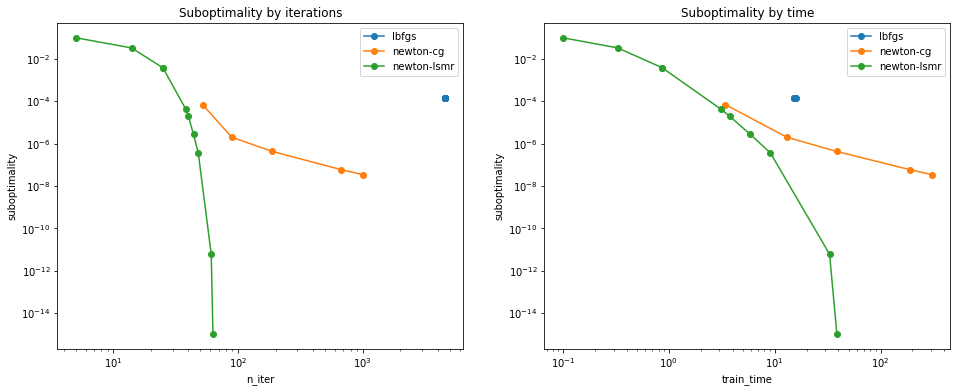

In [6]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


filepath = Path().resolve() / "bench_multinomial_logistic_regression_mtpl_dense.csv"

results = pd.read_csv(filepath)
results["suboptimality"] = results["train_loss"] - results["train_loss"].min() + 1e-15

fig, axes = plt.subplots(ncols=2, figsize=(8*2, 6))
for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(
        x="n_iter", y="suboptimality", loglog=True, marker="o", label=label, ax=axes[0]
    )
axes[0].set_ylabel("suboptimality")
axes[0].set_title("Suboptimality by iterations")

for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(
        x="train_time", y="suboptimality", loglog=True, marker="o", label=label, ax=axes[1]
    )
axes[1].set_ylabel("suboptimality")
axes[1].set_title("Suboptimality by time")
plt.show()

### 1.3. 20 newsgroups
#### Almost unpenalized

In [7]:
import warnings
from pathlib import Path
import numpy as np
from scipy import sparse
from sklearn._loss import HalfMultinomialLoss
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd

In [8]:
X, y = fetch_20newsgroups_vectorized(subset="all", return_X_y=True)
y = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.5, test_size=0.5, random_state=0
)
print(f"{X_train.shape = }")
print(f"{sparse.issparse(X_train)=}")
n_classes = len(np.unique(y_train))
print(f"{n_classes=}")
print("y_train.value_counts() :")
print(pd.Series(y_train).value_counts())


results = []
slow_solvers = set()
loss_sw = np.full_like(y_train, fill_value=(1. / y_train.shape[0]))
alpha = 1e-12
print(f"l2_reg_strength={alpha/X.shape[0]}")
for tol in np.logspace(-1, -10, 10):
    for solver in ["lbfgs", "newton-cg", "newton-lsmr"]:
        if solver in slow_solvers:
            # skip slow solvers to keep the benchmark runtime reasonable
            continue
        tic = perf_counter()
        # with warnings.catch_warnings():
        #     warnings.filterwarnings("ignore", category=ConvergenceWarning)
        clf = LogisticRegression(
            C=1/alpha, solver=solver, tol=tol, max_iter=10_000 if solver=="lbfgs" else 300
        ).fit(X_train, y_train)
        toc = perf_counter()
        train_time = toc - tic
        n_iter = clf.n_iter_[0]
        if train_time > 200 or n_iter >= clf.max_iter:
            # skip this solver from now on...
            slow_solvers.add(solver)
        # Look inside _GeneralizedLinearRegressor to check the parameters.
        # Or run once with verbose=1 and compare to the reported loss.
        train_loss = LinearModelLoss(
            base_loss=HalfMultinomialLoss(n_classes=n_classes), fit_intercept=clf.fit_intercept
        ).loss(
            coef=np.c_[clf.coef_, clf.intercept_],
            X=X_train,
            y=y_train,
            l2_reg_strength=alpha / X_train.shape[0],
            sample_weight=loss_sw,
        )
        result = {
            "solver": solver,
            "tol": tol,
            "train_loss": train_loss,
            "train_time": train_time,
            "train_score": clf.score(X_train, y_train),
            "test_score": clf.score(X_test, y_test),
            "n_iter": n_iter,
            "converged": n_iter < clf.max_iter,
        }
        print(result)
        results.append(result)


results = pd.DataFrame.from_records(results)
filepath = Path().resolve() / "bench_multinomial_logistic_regression_20newsgroup.csv"
results.to_csv(filepath)

X_train.shape = (9423, 130107)
sparse.issparse(X_train)=True
n_classes=20
y_train.value_counts() :
10.0    529
7.0     511
15.0    506
12.0    499
14.0    497
8.0     496
5.0     494
13.0    494
11.0    492
2.0     490
3.0     484
1.0     479
4.0     479
6.0     476
9.0     469
17.0    461
16.0    446
0.0     403
18.0    387
19.0    331
dtype: int64
l2_reg_strength=5.3061657646184865e-17
{'solver': 'lbfgs', 'tol': 0.1, 'train_loss': 0.00024072038402909673, 'train_time': 31.939832549999892, 'train_score': 1.0, 'test_score': 0.8404966571155683, 'n_iter': 89, 'converged': True}
{'solver': 'newton-cg', 'tol': 0.1, 'train_loss': 0.00039439618415178706, 'train_time': 36.08560347899993, 'train_score': 1.0, 'test_score': 0.8750928579008809, 'n_iter': 11, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 0.1, 'train_loss': 0.0003298564847793821, 'train_time': 9.701729847000024, 'train_score': 0.9997877533694153, 'test_score': 0.8997134670487106, 'n_iter': 1, 'converged': True}
{'solver': 'lbf

/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


{'solver': 'newton-cg', 'tol': 1e-06, 'train_loss': 2.52865032001237e-08, 'train_time': 151.0573313330001, 'train_score': 1.0, 'test_score': 0.8784888039902367, 'n_iter': 300, 'converged': False}
{'solver': 'newton-lsmr', 'tol': 1e-06, 'train_loss': 1.6281669984467293e-06, 'train_time': 121.50261462300023, 'train_score': 1.0, 'test_score': 0.8929215748699989, 'n_iter': 3, 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-07, 'train_loss': 2.1974730924494106e-09, 'train_time': 49.3890974699998, 'train_score': 1.0, 'test_score': 0.8337047649368566, 'n_iter': 135, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-07, 'train_loss': 8.629130620416836e-08, 'train_time': 120.83360728600019, 'train_score': 1.0, 'test_score': 0.8965297675899395, 'n_iter': 6, 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-08, 'train_loss': 7.216431400566044e-10, 'train_time': 85.10779890499998, 'train_score': 1.0, 'test_score': 0.8548233046800382, 'n_iter': 251, 'converged': True}
{'solver': 'newton-lsmr',

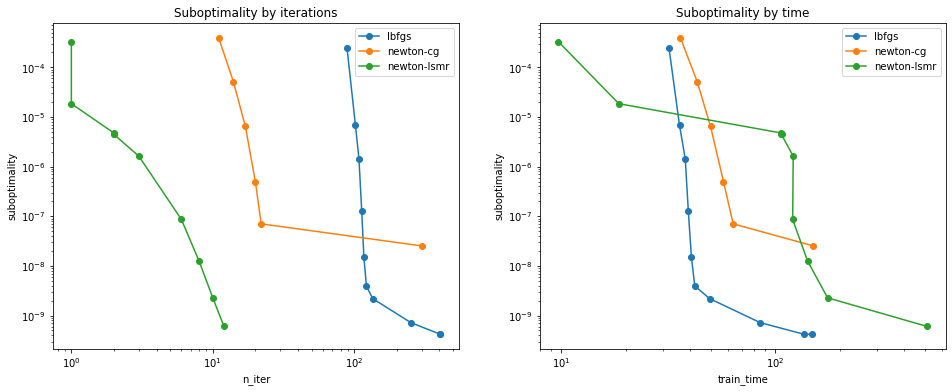

In [18]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


filepath = Path().resolve() / "bench_multinomial_logistic_regression_20newsgroup.csv"

# We know the minimum is 0
loss_min = 0  # results["train_loss"].min()

results = pd.read_csv(filepath)
results["suboptimality"] = results["train_loss"] - loss_min + 1e-16

fig, axes = plt.subplots(ncols=2, figsize=(8*2, 6))
for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(
        x="n_iter", y="suboptimality", loglog=True, marker="o", label=label, ax=axes[0]
    )
axes[0].set_ylabel("suboptimality")
axes[0].set_title("Suboptimality by iterations")

for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(
        x="train_time", y="suboptimality", loglog=True, marker="o", label=label, ax=axes[1]
    )
axes[1].set_ylabel("suboptimality")
axes[1].set_title("Suboptimality by time")
plt.show()

#### Modest penalty

In [10]:
import warnings
from pathlib import Path
import numpy as np
from scipy import sparse
from sklearn._loss import HalfMultinomialLoss
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd

In [11]:
X, y = fetch_20newsgroups_vectorized(subset="all", return_X_y=True)
y = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.5, test_size=0.5, random_state=0
)
print(f"{X_train.shape = }")
print(f"{sparse.issparse(X_train)=}")
n_classes = len(np.unique(y_train))
print(f"{n_classes=}")
print("y_train.value_counts() :")
print(pd.Series(y_train).value_counts())


results = []
slow_solvers = set()
loss_sw = np.full_like(y_train, fill_value=(1. / y_train.shape[0]))
alpha = 1
print(f"l2_reg_strength={alpha/X.shape[0]}")
for tol in np.logspace(-1, -10, 10):
    for solver in ["lbfgs", "newton-cg", "newton-lsmr"]:
        if solver in slow_solvers:
            # skip slow solvers to keep the benchmark runtime reasonable
            continue
        tic = perf_counter()
        # with warnings.catch_warnings():
        #     warnings.filterwarnings("ignore", category=ConvergenceWarning)
        clf = LogisticRegression(
            C=1/alpha, solver=solver, tol=tol, max_iter=10_000 if solver=="lbfgs" else 300
        ).fit(X_train, y_train)
        toc = perf_counter()
        train_time = toc - tic
        n_iter = clf.n_iter_[0]
        if train_time > 200 or n_iter >= clf.max_iter:
            # skip this solver from now on...
            slow_solvers.add(solver)
        # Look inside _GeneralizedLinearRegressor to check the parameters.
        # Or run once with verbose=1 and compare to the reported loss.
        train_loss = LinearModelLoss(
            base_loss=HalfMultinomialLoss(n_classes=n_classes), fit_intercept=clf.fit_intercept
        ).loss(
            coef=np.c_[clf.coef_, clf.intercept_],
            X=X_train,
            y=y_train,
            l2_reg_strength=alpha / X_train.shape[0],
            sample_weight=loss_sw,
        )
        result = {
            "solver": solver,
            "tol": tol,
            "train_loss": train_loss,
            "train_time": train_time,
            "train_score": clf.score(X_train, y_train),
            "test_score": clf.score(X_test, y_test),
            "n_iter": n_iter,
            "converged": n_iter < clf.max_iter,
        }
        print(result)
        results.append(result)


results = pd.DataFrame.from_records(results)
filepath = Path().resolve() / "bench_multinomial_logistic_regression_20newsgroup_penalized.csv"
results.to_csv(filepath)

X_train.shape = (9423, 130107)
sparse.issparse(X_train)=True
n_classes=20
y_train.value_counts() :
10.0    529
7.0     511
15.0    506
12.0    499
14.0    497
8.0     496
5.0     494
13.0    494
11.0    492
2.0     490
3.0     484
1.0     479
4.0     479
6.0     476
9.0     469
17.0    461
16.0    446
0.0     403
18.0    387
19.0    331
dtype: int64
l2_reg_strength=5.3061657646184864e-05
{'solver': 'lbfgs', 'tol': 0.1, 'train_loss': 1.618697770712165, 'train_time': 38.590389550000054, 'train_score': 0.8797622837737451, 'test_score': 0.775549188156638, 'n_iter': 96, 'converged': True}
{'solver': 'newton-cg', 'tol': 0.1, 'train_loss': 1.6186975767450917, 'train_time': 9.165175215999625, 'train_score': 0.8796561604584527, 'test_score': 0.7757614347872227, 'n_iter': 9, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 0.1, 'train_loss': 1.7290700379429031, 'train_time': 2.6405239509999774, 'train_score': 0.8736071314867877, 'test_score': 0.7901942056669851, 'n_iter': 2, 'converged': True

/Users/lorentzen/github/python3_sklearn/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


{'solver': 'newton-cg', 'tol': 1e-08, 'train_loss': 1.6186972504137822, 'train_time': 34.41269656199984, 'train_score': 0.8797622837737451, 'test_score': 0.7757614347872227, 'n_iter': 19, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-08, 'train_loss': 1.6186972504137838, 'train_time': 20.05967276299998, 'train_score': 0.8797622837737451, 'test_score': 0.7757614347872227, 'n_iter': 7, 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-09, 'train_loss': 1.618697272311927, 'train_time': 48.923003240999606, 'train_score': 0.8797622837737451, 'test_score': 0.7757614347872227, 'n_iter': 117, 'converged': True}


/Users/lorentzen/github/python3_sklearn/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


{'solver': 'newton-cg', 'tol': 1e-09, 'train_loss': 1.6186972504137822, 'train_time': 36.1835074239998, 'train_score': 0.8797622837737451, 'test_score': 0.7757614347872227, 'n_iter': 19, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-09, 'train_loss': 1.6186972504137838, 'train_time': 17.595025589000215, 'train_score': 0.8797622837737451, 'test_score': 0.7757614347872227, 'n_iter': 7, 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-10, 'train_loss': 1.618697272311927, 'train_time': 46.683688672000244, 'train_score': 0.8797622837737451, 'test_score': 0.7757614347872227, 'n_iter': 117, 'converged': True}


/Users/lorentzen/github/python3_sklearn/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


{'solver': 'newton-cg', 'tol': 1e-10, 'train_loss': 1.6186972504137822, 'train_time': 32.766633301000184, 'train_score': 0.8797622837737451, 'test_score': 0.7757614347872227, 'n_iter': 19, 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-10, 'train_loss': 1.618697250413784, 'train_time': 21.522521755000525, 'train_score': 0.8797622837737451, 'test_score': 0.7757614347872227, 'n_iter': 8, 'converged': True}


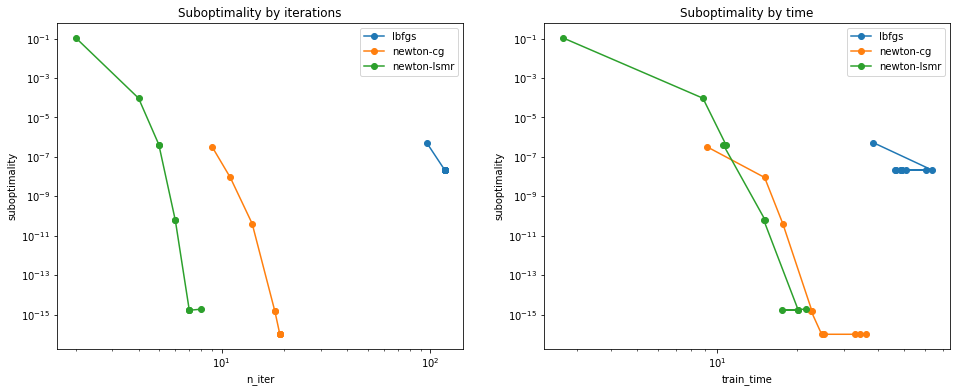

In [12]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


filepath = Path().resolve() / "bench_multinomial_logistic_regression_20newsgroup_penalized.csv"

results = pd.read_csv(filepath)
results["suboptimality"] = results["train_loss"] - results["train_loss"].min() + 1e-16

fig, axes = plt.subplots(ncols=2, figsize=(8*2, 6))
for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(
        x="n_iter", y="suboptimality", loglog=True, marker="o", label=label, ax=axes[0]
    )
axes[0].set_ylabel("suboptimality")
axes[0].set_title("Suboptimality by iterations")

for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(
        x="train_time", y="suboptimality", loglog=True, marker="o", label=label, ax=axes[1]
    )
axes[1].set_ylabel("suboptimality")
axes[1].set_title("Suboptimality by time")
plt.show()

#### Penalty dependence

In [13]:
import warnings
from pathlib import Path
import numpy as np
from scipy import sparse
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd

In [14]:
X, y = fetch_20newsgroups_vectorized(subset="all", return_X_y=True)

In [15]:
X.shape[1] / X.shape[0]

6.903693091372174

In [16]:
print("newton-lsmr")
n=1000
for alpha in [1e2, 1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]:
    tic = perf_counter()
    LogisticRegression(C=1/alpha, solver="newton-lsmr", tol=1e-4).fit(X[n:,:], y[n:])
    toc = perf_counter()
    train_time = toc - tic
    print(f"{alpha=:10} {train_time=:11f} l2_regularization_strength={alpha/n}")

newton-lsmr
alpha=     100.0 train_time=   4.249304 l2_regularization_strength=0.1
alpha=         1 train_time=  24.933094 l2_regularization_strength=0.001
alpha=      0.01 train_time=  77.201585 l2_regularization_strength=1e-05
alpha=    0.0001 train_time=  50.275259 l2_regularization_strength=1.0000000000000001e-07
alpha=     1e-06 train_time= 127.260929 l2_regularization_strength=9.999999999999999e-10
alpha=     1e-08 train_time= 152.065511 l2_regularization_strength=1.0000000000000001e-11
alpha=     1e-10 train_time= 163.241251 l2_regularization_strength=1e-13
alpha=     1e-12 train_time= 146.779938 l2_regularization_strength=1e-15


In [17]:
print("lbfgs")
n=1000
for alpha in [1e2, 1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]:
    tic = perf_counter()
    LogisticRegression(C=1/alpha, solver="lbfgs", tol=1e-4, max_iter=10_000).fit(X[n:,:], y[n:])
    toc = perf_counter()
    train_time = toc - tic
    print(f"{alpha=:10} {train_time=:11f} l2_regularization_strength={alpha/n}")

lbfgs
alpha=     100.0 train_time=  10.139987 l2_regularization_strength=0.1
alpha=         1 train_time=  66.961889 l2_regularization_strength=0.001
alpha=      0.01 train_time= 226.269008 l2_regularization_strength=1e-05
alpha=    0.0001 train_time= 418.701937 l2_regularization_strength=1.0000000000000001e-07
alpha=     1e-06 train_time= 779.384704 l2_regularization_strength=9.999999999999999e-10
alpha=     1e-08 train_time= 542.209868 l2_regularization_strength=1.0000000000000001e-11
alpha=     1e-10 train_time= 347.757309 l2_regularization_strength=1e-13
alpha=     1e-12 train_time= 114.669929 l2_regularization_strength=1e-15


## 2. Play around
### Poisson on freMTPL

In [1]:
import warnings
from pathlib import Path
import numpy as np
from scipy import sparse
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd


def prepare_data():
    df = fetch_openml(data_id=41214, as_frame=True, parser='auto').frame
    df["Frequency"] = df["ClaimNb"] / df["Exposure"]
    log_scale_transformer = make_pipeline(
        FunctionTransformer(np.log, validate=False), StandardScaler()
    )
    linear_model_preprocessor = ColumnTransformer(
        [
            ("passthrough_numeric", "passthrough", ["BonusMalus"]),
            (
                "binned_numeric",
                KBinsDiscretizer(n_bins=10, subsample=None),
                ["VehAge", "DrivAge"],
            ),
            ("log_scaled_numeric", log_scale_transformer, ["Density"]),
            (
                "onehot_categorical",
                OneHotEncoder(),
                ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
            ),
        ],
        remainder="drop",
    )
    y = df["Frequency"]
    w = df["Exposure"]
    X = linear_model_preprocessor.fit_transform(df)
    return X, np.asarray(y), np.asarray(w)


X, y, w = prepare_data()
#X = X.toarray()
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, train_size=0.8, test_size=0.1, random_state=0
)
print(f"{X_train.shape = }")
print(f"{sparse.issparse(X_train)=}")

X_train.shape = (542410, 75)
sparse.issparse(X_train)=True


In [2]:
%%time
PoissonRegressor(alpha=1e-12, solver="newton-lsmr", tol=1e-5).fit(X_train, y_train, sample_weight=w_train)

CPU times: user 6.81 s, sys: 2.57 s, total: 9.38 s
Wall time: 1.86 s


PoissonRegressor(alpha=1e-12, solver='newton-lsmr', tol=1e-05)

In [5]:
%%time
PoissonRegressor(alpha=1e-12, solver="newton-lsmr", tol=1e-5, inner_stopping={"artol": (0.5, 1, 0.5, False)}, verbose=0).fit(X_train, y_train, sample_weight=w_train)

CPU times: user 7.82 s, sys: 1.6 s, total: 9.42 s
Wall time: 1.59 s


PoissonRegressor(alpha=1e-12, inner_stopping={'artol': (0.5, 1, 0.5, False)},
                 solver='newton-lsmr', tol=1e-05)

In [6]:
%%time
PoissonRegressor(alpha=1e-12, solver="newton-lsmr", tol=1e-5, inner_stopping={"qtol": (0.5, 1, 0.5, False)}, verbose=0).fit(X_train, y_train, sample_weight=w_train)

CPU times: user 8.96 s, sys: 1.7 s, total: 10.7 s
Wall time: 1.64 s


PoissonRegressor(alpha=1e-12, inner_stopping={'qtol': (0.5, 1, 0.5, False)},
                 solver='newton-lsmr', tol=1e-05)

In [7]:
%%time
PoissonRegressor(alpha=1e-12, solver="newton-lsmr", tol=1e-2, verbose=3).fit(X_train, y_train, sample_weight=w_train)

Newton iter=1
    norm(gradient)=0.5552862628646045 eta=0.5
    A_norm=1 r_norm=1 Ar_norm=1 atol=0.2776428537894485
  Inner iterations in LSMR = 1, total = 1
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.00041535801218245405 <= -4.193067677650515e-07 True
  Check Convergence
    loss = 0.33284730619356984.
    1. max |gradient| 0.029012028459036898 <= 0.01
Newton iter=2
    norm(gradient)=0.03966796162167179 eta=0.19916817421885402
    A_norm=18.92712387193105 r_norm=2.328738985419083 Ar_norm=0.026667251379384832 atol=0.0001792480247158106
  Inner iterations in LSMR = 4, total = 5
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.013094296241375813 <= -1.3219819403456386e-05 True
  Check Convergence
    loss = 0.319753009952194.
    1. max |gradient| 1.05901044534

PoissonRegressor(alpha=1e-12, solver='newton-lsmr', tol=0.01, verbose=3)

### Logistic on freMTPL

In [1]:
import numpy as np
from scipy import sparse
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split


def prepare_data():
    df = fetch_openml(data_id=41214, as_frame=True, parser='auto').frame
    df["Frequency"] = df["ClaimNb"] / df["Exposure"]
    log_scale_transformer = make_pipeline(
        FunctionTransformer(np.log, validate=False), StandardScaler()
    )
    linear_model_preprocessor = ColumnTransformer(
        [
            ("passthrough_numeric", "passthrough", ["BonusMalus"]),
            (
                "binned_numeric",
                KBinsDiscretizer(n_bins=10, subsample=None),
                ["VehAge", "DrivAge"],
            ),
            ("log_scaled_numeric", log_scale_transformer, ["Density"]),
            (
                "onehot_categorical",
                OneHotEncoder(),
                ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
            ),
        ],
        remainder="drop",
    )
    y = df["Frequency"]
    w = df["Exposure"]
    X = linear_model_preprocessor.fit_transform(df)
    return X, y, w


X, y_orig, w = prepare_data()

print("binning the target...")
binner = KBinsDiscretizer(
    n_bins=300, encode="ordinal", strategy="quantile", subsample=int(2e5), random_state=0
)
y = binner.fit_transform(y_orig.to_numpy().reshape(-1, 1)).ravel().astype(np.int32)

#X = X.toarray()
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, train_size=10_000, test_size=10_000, random_state=0
)

binning the target...


/Users/lorentzen/github/scikit-learn/sklearn/preprocessing/_discretization.py:312: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [2]:
%%time
LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-5
).fit(X_train, y_train)

CPU times: user 5.38 s, sys: 1.61 s, total: 6.99 s
Wall time: 1.78 s


LogisticRegression(C=1000000000000.0, solver='newton-lsmr', tol=1e-05)

In [3]:
%%time
LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-5, inner_stopping={"artol": (0.5, 1, 0.5, False)}
).fit(X_train, y_train)

CPU times: user 19.7 s, sys: 5.99 s, total: 25.7 s
Wall time: 6.47 s


LogisticRegression(C=1000000000000.0,
                   inner_stopping={'artol': (0.5, 1, 0.5, False)},
                   solver='newton-lsmr', tol=1e-05)

In [4]:
%%time
LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-5, inner_stopping={"qtol": (0.5, 1, 0.5, False)}
).fit(X_train, y_train)

CPU times: user 9.95 s, sys: 3.14 s, total: 13.1 s
Wall time: 3.32 s


LogisticRegression(C=1000000000000.0,
                   inner_stopping={'qtol': (0.5, 1, 0.5, False)},
                   solver='newton-lsmr', tol=1e-05)

In [5]:
%%time
LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-5, inner_stopping={"qtol": (-1, 1, 0.5, True)}
).fit(X_train, y_train)

CPU times: user 7.69 s, sys: 2.25 s, total: 9.94 s
Wall time: 2.51 s


LogisticRegression(C=1000000000000.0,
                   inner_stopping={'qtol': (-1, 1, 0.5, True)},
                   solver='newton-lsmr', tol=1e-05)

In [7]:
%%time
LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-2, inner_stopping={"qtol": (-1, 1, 0.5, True)}, verbose=3
).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
    norm(gradient)=53.91594959790576 eta=0.5
    A_norm=1 r_norm=1 Ar_norm=1 atol=0
  Inner iterations in LSMR = 2, total = 2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -1.9247974594495898 <= -0.004564050282284683 True
  Check Convergence
    loss = 0.5601091903384107.
    1. max |gradient| 3.146579789937196 <= 0.01
Newton iter=2
    norm(gradient)=3.362786060355206 eta=0.0609084983200039
    A_norm=17.848207082755636 r_norm=1.241403723909487 Ar_norm=0.07884653484974849 atol=0
  Inner iterations in LSMR = 3, total = 5
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: 335.52416345790846 <= -0.004459829827021559 False
      check loss |improvement| <= eps * |loss_old|: 335.52416345790846 <= 1.989907582137145e-15 False
    line search iteration=2, step siz

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


LogisticRegression(C=1000000000000.0,
                   inner_stopping={'qtol': (-1, 1, 0.5, True)},
                   solver='newton-lsmr', tol=0.01, verbose=3)

In [8]:
%prun -l 15 LogisticRegression(C=1e12, solver="newton-lsmr", tol=1e-5, max_iter=10000).fit(X_train, y_train)

         284869 function calls (284751 primitive calls) in 1.852 seconds

   Ordered by: internal time
   List reduced from 429 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      504    0.304    0.001    0.382    0.001 _linear_loss.py:762(sqrt_D_Lt_matmul)
      556    0.225    0.000    0.225    0.000 {built-in method scipy.sparse._sparsetools.csc_matvecs}
      528    0.211    0.000    0.211    0.000 {built-in method scipy.sparse._sparsetools.csr_matvecs}
     4785    0.158    0.000    0.158    0.000 {method 'ravel' of 'numpy.ndarray' objects}
      503    0.134    0.000    0.170    0.000 _linear_loss.py:816(L_sqrt_D_matmul)
      503    0.119    0.000    0.931    0.002 _newton_solver.py:931(matvec)
     1007    0.108    0.000    0.108    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
       23    0.082    0.004    1.596    0.069 lsmr.py:30(lsmr)
       30    0.039    0.001    0.039    0.001 loss.py:198(loss_grad

In [9]:
%prun -l 15 LogisticRegression(C=1e12, solver="newton-lsmr", tol=1e-5, max_iter=10000).fit(X_train, y_train)

         284869 function calls (284751 primitive calls) in 2.203 seconds

   Ordered by: internal time
   List reduced from 429 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      504    0.372    0.001    0.465    0.001 _linear_loss.py:762(sqrt_D_Lt_matmul)
      556    0.250    0.000    0.250    0.000 {built-in method scipy.sparse._sparsetools.csc_matvecs}
      528    0.236    0.000    0.236    0.000 {built-in method scipy.sparse._sparsetools.csr_matvecs}
     4785    0.175    0.000    0.175    0.000 {method 'ravel' of 'numpy.ndarray' objects}
      503    0.165    0.000    0.211    0.000 _linear_loss.py:816(L_sqrt_D_matmul)
      503    0.149    0.000    1.114    0.002 _newton_solver.py:931(matvec)
     1007    0.130    0.000    0.130    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
       23    0.109    0.005    1.938    0.084 lsmr.py:30(lsmr)
12839/12722    0.047    0.000    0.259    0.000 {built-in method nu

In [2]:
%%time
LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-10, inner_stopping={"atol": (0.5, 1, 0.5, False)}, verbose=3
).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
    norm(gradient)=5.392e+01 eta=5.000e-01
    A_norm=1.000e+00 r_norm=1.000e+00 Ar_norm=1.000e+00 atol=2.696e+01
    b_norm=3.317e+00 btol=1.000e-10
  Inner iterations in LSMR = 1, total = 1, istop = 1 normx = 1.693e-01
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -1.9235808991289154 <= -0.004456079227475797 True
  Check Convergence
    loss = 0.561325750659085.
    1. max |gradient| 3.1264108664258266 <= 1e-10
Newton iter=2
    norm(gradient)=3.342e+00 eta=5.000e-01
    A_norm=1.785e+01 r_norm=1.369e+00 Ar_norm=1.109e-01 atol=4.294e-01
    b_norm=3.678e+04 btol=1.000e-10
  Inner iterations in LSMR = 1, total = 2, istop = 2 normx = 1.186e+00
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: 71.99365610556367 <= -0.0019356451099753098 False
      check lo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.8s finished


LogisticRegression(C=1000000000000.0,
                   inner_stopping={'atol': (0.5, 1, 0.5, False)},
                   solver='newton-lsmr', tol=1e-10, verbose=3)

### 20 newsgroup

In [3]:
import warnings
from pathlib import Path
import numpy as np
from scipy import sparse
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd

In [4]:
X, y = fetch_20newsgroups_vectorized(subset="all", return_X_y=True)
y = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.5, test_size=0.5, random_state=0
)

In [3]:
X.shape[1] / X.shape[0]

6.903693091372174

In [4]:
loss_sw = np.full_like(y_train, fill_value=(1. / y_train.shape[0]))
alpha = 1e-12

tol = 1e-3
solver = "newton-lsmr"
clf = LogisticRegression(C=1/alpha, solver=solver, tol=tol, max_iter=300)

%time clf = clf.fit(X_train, y_train)

CPU times: user 8min 18s, sys: 2min 44s, total: 11min 3s
Wall time: 2min 46s


In [5]:
tol = 1e-4
solver = "newton-lsmr"
clf = LogisticRegression(C=1/alpha, solver=solver, tol=tol, max_iter=300)

%time clf = clf.fit(X_train, y_train)

CPU times: user 8min 12s, sys: 2min 42s, total: 10min 55s
Wall time: 2min 44s


In [6]:
%%time
LogisticRegression(
    C=1e2, solver="newton-lsmr", tol=1e-5, max_iter=10000,
).fit(X[:1000, :2000], y[:1000])

CPU times: user 557 ms, sys: 191 ms, total: 748 ms
Wall time: 189 ms


LogisticRegression(C=100.0, max_iter=10000, solver='newton-lsmr', tol=1e-05)

In [7]:
clf = LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-5, max_iter=10000,
)

In [8]:
%time clf.fit(X[:1000, :2000], y[:1000])

CPU times: user 17.6 s, sys: 5.25 s, total: 22.9 s
Wall time: 5.73 s


LogisticRegression(C=1000000000000.0, max_iter=10000, solver='newton-lsmr',
                   tol=1e-05)

In [9]:
%%time
clf = LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-3, max_iter=10000,
).fit(X, y)

CPU times: user 1min 38s, sys: 31.3 s, total: 2min 9s
Wall time: 32.9 s


In [10]:
%%time
clf = LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-4, max_iter=10000,
).fit(X, y)

CPU times: user 7min 55s, sys: 2min 28s, total: 10min 24s
Wall time: 2min 37s


In [11]:
%prun -l 15 clf.fit(X[:1000, :2000], y[:1000])

         248028 function calls (247960 primitive calls) in 0.720 seconds

   Ordered by: internal time
   List reduced from 442 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       13    0.097    0.007    0.650    0.050 lsmr.py:30(lsmr)
      445    0.070    0.000    0.087    0.000 _linear_loss.py:762(sqrt_D_Lt_matmul)
     4151    0.063    0.000    0.063    0.000 {method 'ravel' of 'numpy.ndarray' objects}
      444    0.063    0.000    0.224    0.001 _newton_solver.py:954(rmatvec)
      444    0.046    0.000    0.056    0.000 _linear_loss.py:816(L_sqrt_D_matmul)
      444    0.043    0.000    0.305    0.001 _newton_solver.py:931(matvec)
11123/11056    0.038    0.000    0.092    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      889    0.021    0.000    0.021    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
     2730    0.019    0.000    0.041    0.000 _sputils.py:147(get_index_dt

In [12]:
%load_ext line_profiler

In [13]:
from sklearn.linear_model._glm._newton_solver import NewtonLSMRSolver

In [14]:
%lprun -f NewtonLSMRSolver.compute_A_b clf.fit(X[:1000, :2000], y[:1000])

Timer unit: 1e-06 s

Total time: 0.028313 s
File: /Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py
Function: compute_A_b at line 816

Line #      Hits         Time  Per Hit   % Time  Line Contents
   816                                               def compute_A_b(self, X, y, sample_weight):
   817                                                   """Compute A and b for IRLS formulation.
   818                                           
   819                                                   Returns
   820                                                   -------
   821                                                   A : LinearOperator of shape (n_samples + n_features, n_dof) or \
   822                                                       (n_samples + n_features) * n_classes, n_dof * n_classes)
   823                                                       For the multiclass case, `A @ x` expects `x = coef.ravel(order="C")` for
   824                

In [6]:
%%time
clf = LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-4, verbose=3
).fit(X_train, y_train)
clf.convergence_report

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
    norm(gradient)=4.198e-02 eta=2.049e-01
    A_norm=2.991e+02 r_norm=1.000e+00 Ar_norm=1.000e+00 atol=2.875e-05
    b_norm=4.359e+00 btol=1.000e-04
  Inner iterations in LSMR = 161, total = 161, istop = 1 normx = 3.249e+03
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -2.9957191636066325 <= -0.009260375809032516 True
  Check Convergence
    loss = 1.3109947358549392e-05.
    1. max |gradient| 6.421697059976248e-06 <= 0.0001
    2. Newton decrement 0.0010053777847841734 <= 0.0001
Newton iter=2
    norm(gradient)=1.281e-05 eta=3.579e-03
    A_norm=1.385e+00 r_norm=1.298e-01 Ar_norm=3.247e-05 atol=8.564e-07
    b_norm=3.690e-03 btol=1.000e-04
  Inner iterations in LSMR = 668, total = 829, istop = 2 normx = 1.126e+02
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armi

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished


array([[{'iteration': 1, 'time': 20.28272855299997, 'loss': 1.3109947358549392e-05, 'fallback_lbfgs': False, 'inner_iteration': 161},
        {'iteration': 2, 'time': 115.48330672199995, 'loss': 4.57493348172439e-06, 'fallback_lbfgs': False, 'inner_iteration': 829}]],
      dtype=object)

In [7]:
%%time
# What changes with another seed?
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, train_size=0.5, test_size=0.5, random_state=42 ** 2
)

clf = LogisticRegression(
    C=1e12, solver="newton-lsmr", tol=1e-4, verbose=3
).fit(X_train2, y_train2)
clf.convergence_report

Newton iter=1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    norm(gradient)=4.247e-02 eta=2.061e-01
    A_norm=2.991e+02 r_norm=1.000e+00 Ar_norm=1.000e+00 atol=2.926e-05
    b_norm=4.359e+00 btol=1.000e-04
  Inner iterations in LSMR = 160, total = 160, istop = 1 normx = 3.243e+03
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -2.995680361713784 <= -0.009260590643503512 True
  Check Convergence
    loss = 5.191184020696949e-05.
    1. max |gradient| 1.0969754464579163e-06 <= 0.0001
    2. Newton decrement 0.0010054297626574023 <= 0.0001
Newton iter=2
    norm(gradient)=3.525e-06 eta=1.877e-03
    A_norm=1.384e+00 r_norm=1.302e-01 Ar_norm=3.203e-05 atol=3.278e-07
    b_norm=7.464e-03 btol=1.000e-04
  Inner iterations in LSMR = 1007, total = 1167, istop = 2 normx = 1.182e+02
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -3.4

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


array([[{'iteration': 1, 'time': 25.723772326000017, 'loss': 5.191184020696949e-05, 'fallback_lbfgs': False, 'inner_iteration': 160},
        {'iteration': 2, 'time': 195.023665681, 'loss': 1.7240768046791088e-05, 'fallback_lbfgs': False, 'inner_iteration': 1167}]],
      dtype=object)

In [8]:
%%time
LogisticRegression(
    C=1e12, solver="newton-cg", tol=1e-4, verbose=3
).fit(X_train2, y_train2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 4min 7s, sys: 1min 26s, total: 5min 33s
Wall time: 1min 25s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


LogisticRegression(C=1000000000000.0, solver='newton-cg', verbose=3)

## 3. Inner Stopping Criteria

The argument `inner_stopping` must be a dict of the form `{"criterion": (c0, c1, c2, track_loss)}`.
Criterion can be
- `"atol"` of the original LSMR, stops when `||A' r|| <= ||A|| * ||r|| * atol `.
- `"artol"` extention of LSMR, stops when `||A'r|| <= artol`
- `"qtol"` extention of LSMR, stops when `||r||^2 - ||b||^2 = xHx - 2Gx <= qtol`.

`c0, c1, c2` specify `eta = min(c0, c1 * ||G||^2)` with special values
- `c0=-1`: `eta = (||G|| - ||A' r||) / ||G_old||`
- `c0=-1`: `eta = (||G|| / ||G_old||)^2`

See Nash "A survey of truncated-Newton methods".

Then `track_loss` is bool.
If `True`, then at Newton iteration `i`, if `loss improvement(iter i-1) < loss improvement(iter i-2)` and `||G(i)|| > ||G(i-1)||` (gradient is computed at the beginning of an iteration, loss at the end), then `eta(i) = eta(i-1)`.

### Poisson Regression on freMTPL

In [3]:
%%time
import warnings
import numpy as np
from scipy import sparse
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd
import matplotlib.pyplot as plt


def prepare_data():
    df = fetch_openml(data_id=41214, as_frame=True, parser='auto').frame
    df["Frequency"] = df["ClaimNb"] / df["Exposure"]
    log_scale_transformer = make_pipeline(
        FunctionTransformer(np.log, validate=False), StandardScaler()
    )
    linear_model_preprocessor = ColumnTransformer(
        [
            ("passthrough_numeric", "passthrough", ["BonusMalus"]),
            (
                "binned_numeric",
                KBinsDiscretizer(n_bins=10, subsample=None),
                ["VehAge", "DrivAge"],
            ),
            ("log_scaled_numeric", log_scale_transformer, ["Density"]),
            (
                "onehot_categorical",
                OneHotEncoder(),
                ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
            ),
        ],
        remainder="drop",
    )
    y = df["Frequency"]
    w = df["Exposure"]
    X = linear_model_preprocessor.fit_transform(df)
    return X, np.asarray(y), np.asarray(w)


X, y, w = prepare_data()
#X = X.toarray()
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, train_size=0.8, test_size=0.1, random_state=0
)
print(f"{X_train.shape = }")
print(f"{sparse.issparse(X_train)=}")

results = []
loss_sw = w_train / w_train.sum()
solver = "newton-lsmr"
tol = 1e-10
for inner_stopping in [
    {"atol": (0.5, 0.5, 0.5, False)},
    {"atol": (0.5, 1, 0.5, False)},
    {"atol": (0.5, 1, 0.5, True)},
    {"atol": (0.5, 2, 0.5, False)},
    {"atol": (-1, None, None, False)},
    {"atol": (-1, None, None, True)},
    {"atol": (-2, None, None, False)},
    {"atol": (-2, None, None, True)},
    {"artol": (0.5, 0.5, 0.5, False)},
    {"artol": (0.5, 1, 0.5, False)},
    {"artol": (0.5, 1, 0.5, True)},
    {"artol": (0.5, 2, 0.5, False)},
    {"artol": (-1, None, None, False)},
    {"artol": (-1, None, None, True)},
    {"artol": (-2, None, None, False)},
    {"artol": (-2, None, None, True)},
    {"qtol": (0.5, 0.5, 0.5, False)},
    {"qtol": (0.5, 1, 0.5, False)},
    {"qtol": (0.5, 1, 0.5, True)},
    {"qtol": (0.5, 2, 0.5, False)},
    {"qtol": (-1, None, None, False)},
    {"qtol": (-1, None, None, True)},
    {"qtol": (-2, None, None, False)},
    {"qtol": (-2, None, None, True)},
    {"atol": (0.5, 1, 0.5, False), "artol": (0.5, 1, 0.5, False)},
]:
    inner_stopping_ratio = "+".join(inner_stopping.keys())
    k = list(inner_stopping.keys())[0]
    c0 = inner_stopping[k][0]
    c1 = inner_stopping[k][1]
    c2 = inner_stopping[k][2]
    track_loss = inner_stopping[k][3]
    tic = perf_counter()
    reg = PoissonRegressor(
        alpha=1e-12,
        solver="newton-lsmr",
        tol=tol,
        max_iter=100,
        inner_stopping=inner_stopping,
    ).fit(X_train, y_train, sample_weight=w_train)
    toc = perf_counter()
    train_time = toc - tic
    n_iter = reg.n_iter_
    # Look inside _GeneralizedLinearRegressor to check the parameters.
    # Or run once with verbose=1 and compare to the reported loss.
    train_loss = LinearModelLoss(
        base_loss=reg._get_loss(), fit_intercept=reg.fit_intercept
    ).loss(
        coef=np.r_[reg.coef_, reg.intercept_],
        X=X_train,
        y=y_train,
        l2_reg_strength=reg.alpha,
        sample_weight=loss_sw,
    )       
    result = {
        "tol": tol,
        "stopping_ratio": inner_stopping_ratio,
        "c0": c0,
        "c1": c1,
        "c2": c2,
        "track_loss": track_loss,
        "train_loss": train_loss,
        "train_time": train_time,
        "n_iter": n_iter,
        "report": reg.convergence_report,
        "converged": n_iter < reg.max_iter,
    }
    results.append(result)

# Get the "true" loss
reg = PoissonRegressor(alpha=1e-12, solver="newton-cholesky", tol=1e-12).fit(X_train, y_train, sample_weight=w_train)
train_loss = LinearModelLoss(
    base_loss=reg._get_loss(), fit_intercept=reg.fit_intercept
).loss(
        coef=np.r_[reg.coef_, reg.intercept_],
        X=X_train,
        y=y_train,
        l2_reg_strength=reg.alpha,
        sample_weight=loss_sw,
)

results = pd.DataFrame.from_records([
    {
        "tol": level1_dict["tol"],
        "stopping_ratio": level1_dict["stopping_ratio"],
        "c0": level1_dict["c0"],
        "c1": level1_dict["c1"],
        "c2": level1_dict["c2"],
        "track_loss": level1_dict["track_loss"],
        "total_time": level1_dict["train_time"],
        "train_loss": level1_dict["train_loss"],
    } | convergence_report
    for level1_dict in results
    for convergence_report in level1_dict["report"]
])
results["suboptimality"] = results["loss"] - train_loss + 1e-16
results

X_train.shape = (542410, 75)
sparse.issparse(X_train)=True
CPU times: user 10min 52s, sys: 2min 16s, total: 13min 8s
Wall time: 2min 12s


,tol,stopping_ratio,c0,c1,c2,track_loss,total_time,train_loss,iteration,time,loss,fallback_lbfgs,inner_iteration,suboptimality
0,1.000000e-10,atol,0.5,0.5,0.5,False,4.655989,0.317291,1,0.105586,0.332847,False,1,1.555645e-02
1,1.000000e-10,atol,0.5,0.5,0.5,False,4.655989,0.317291,2,0.309691,0.320856,False,7,3.565564e-03
2,1.000000e-10,atol,0.5,0.5,0.5,False,4.655989,0.317291,3,0.366796,0.318615,False,8,1.324383e-03
3,1.000000e-10,atol,0.5,0.5,0.5,False,4.655989,0.317291,4,0.418952,0.318589,False,9,1.297961e-03
4,1.000000e-10,atol,0.5,0.5,0.5,False,4.655989,0.317291,5,0.569059,0.317366,False,17,7.475793e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,1.000000e-10,atol+artol,0.5,1.0,0.5,False,4.589220,0.317291,18,2.994301,0.317291,False,156,2.850943e-13
663,1.000000e-10,atol+artol,0.5,1.0,0.5,False,4.589220,0.317291,19,3.093718,0.317291,False,159,2.842061e-13
664,1.000000e-10,atol+artol,0.5,1.0,0.5,False,4.589220,0.317291,20,3.173800,0.317291,False,161,2.839840e-13
665,1.000000e-10,atol+artol,0.5,1.0,0.5,False,4.589220,0.317291,21,3.390245,0.317291,False,173,2.774337e-13


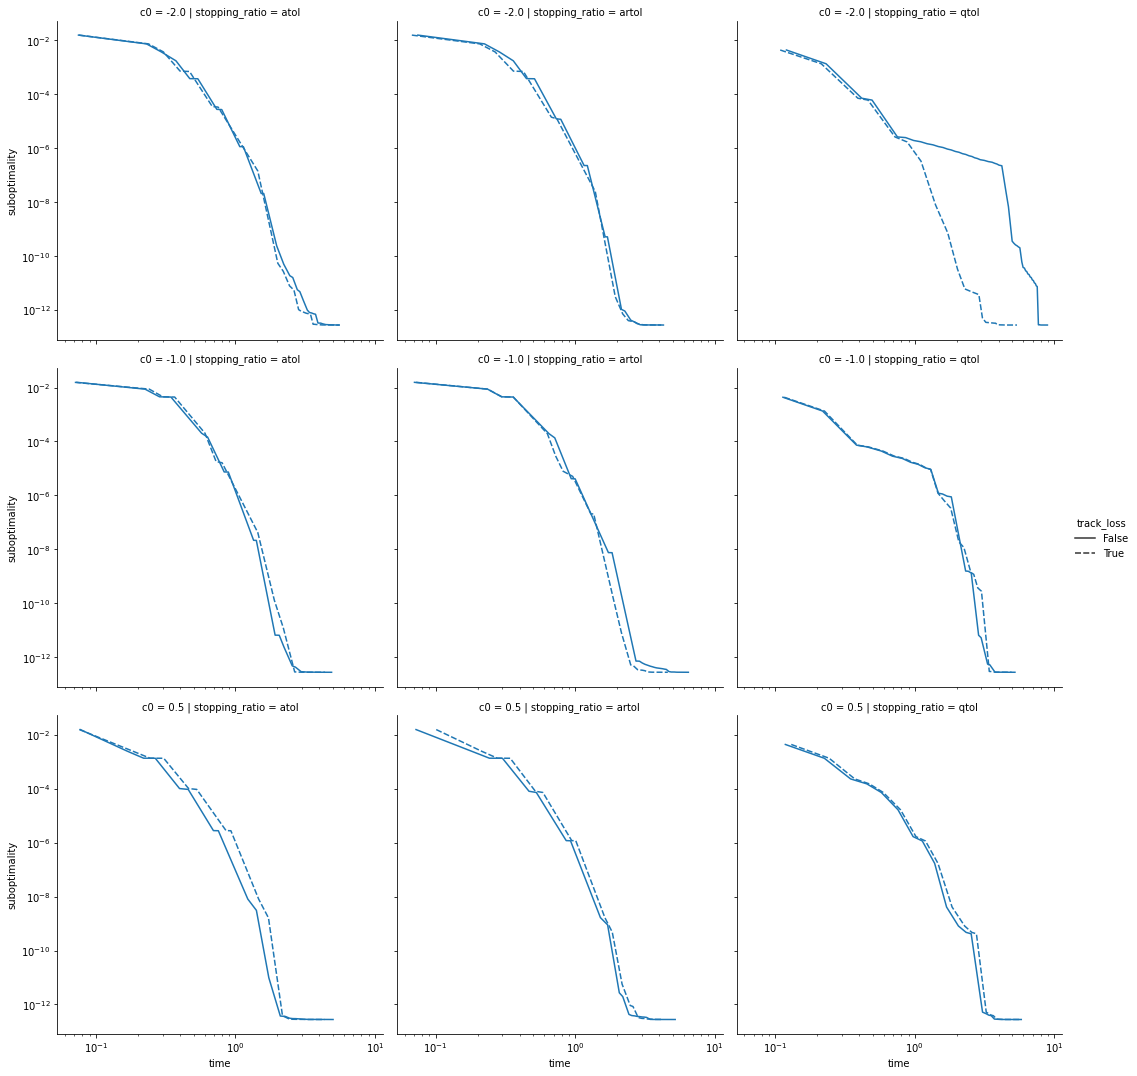

In [45]:
# With or without tracking loss improvement?
results_filtered = results[((results.c1 == 1) | results.c1.isnull()) & (results.stopping_ratio != "atol+artol")].copy()

import seaborn as sns

g = sns.relplot(
    data=results_filtered, x="time", y="suboptimality",
    row="stopping_ratio", col="c0", style="track_loss",
    kind="line"
)
g.set(xscale="log", yscale="log")

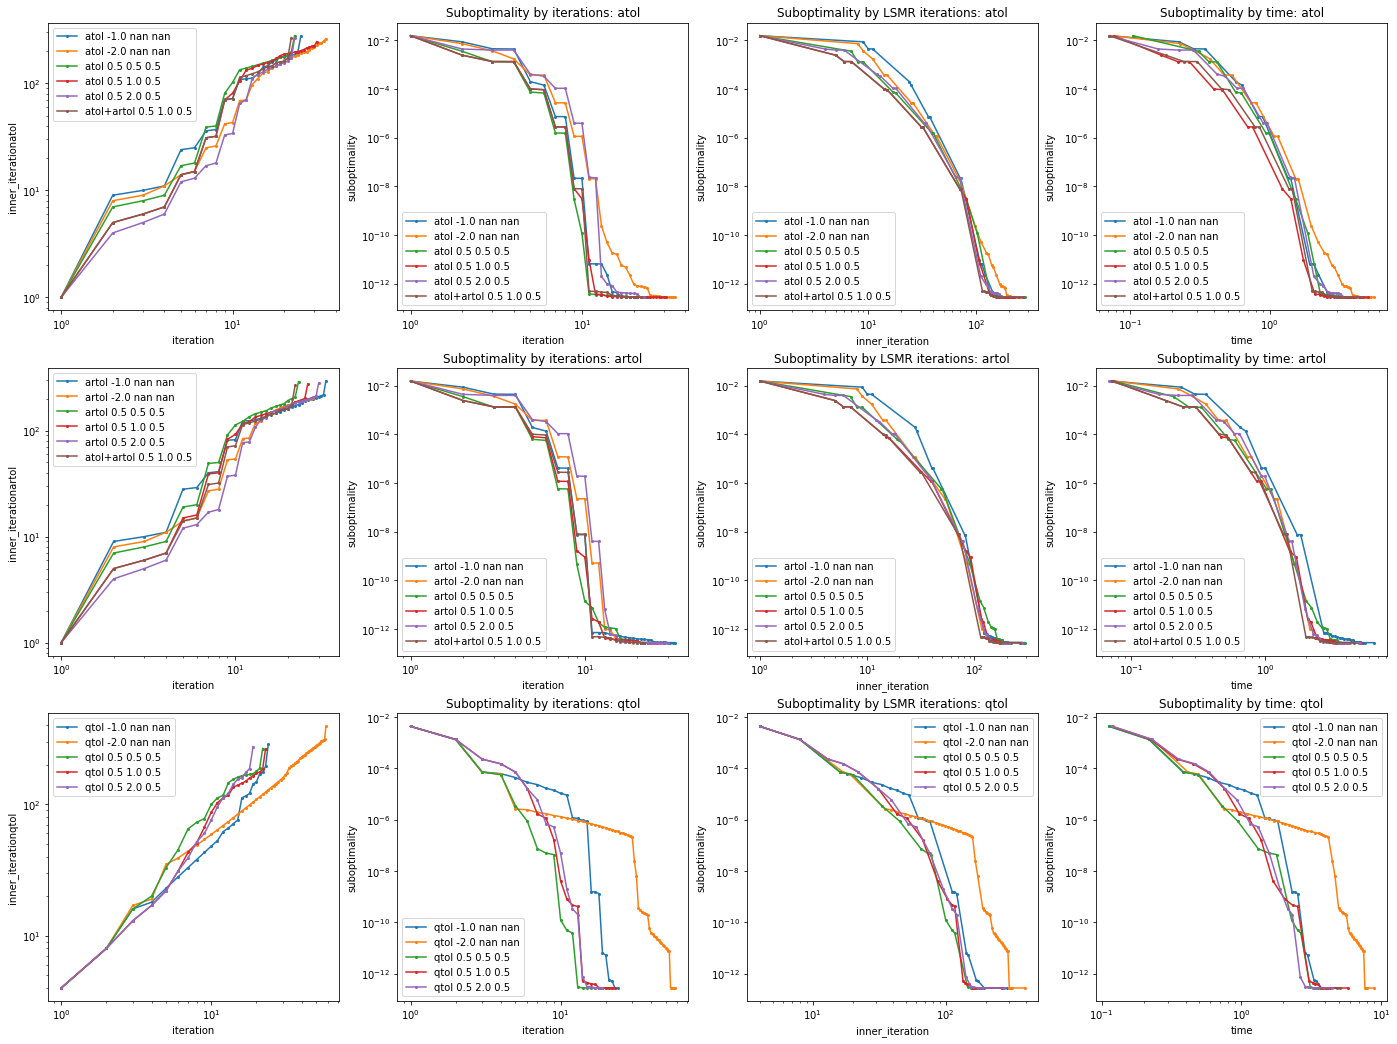

In [52]:
results_filtered = results[results.track_loss == False].copy()
results_filtered["stopping"] = (
    results_filtered["stopping_ratio"]
    + " " + results_filtered["c0"].astype(str)
    + " " + results_filtered["c1"].astype(str)
    + " " + results_filtered["c2"].astype(str)
    #+ " " + results_filtered["track_loss"].astype(str)
)

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(8*3, 6*3))
for i, stop in enumerate(["atol", "artol", "qtol"]):
    for label, group in results_filtered[results_filtered.stopping.str.contains(stop)].groupby("stopping"):
        group.sort_values("iteration").plot(
            x="iteration", y="inner_iteration", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][0]
        )
        group.sort_values("iteration").plot(
            x="iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][1]
        )
        group.sort_values("iteration").plot(
            x="inner_iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][2]
        )
        group.sort_values("iteration").plot(
            x="time", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][3]
        )
    axes[i][0].set_ylabel("inner_iteration" + stop)
    for j in range(1, axes.shape[1]):
        axes[i][j].set_ylabel("suboptimality")
    axes[i][1].set_title("Suboptimality by iterations: " + stop)
    axes[i][2].set_title("Suboptimality by LSMR iterations: " + stop)
    axes[i][3].set_title("Suboptimality by time: " + stop)

plt.show()

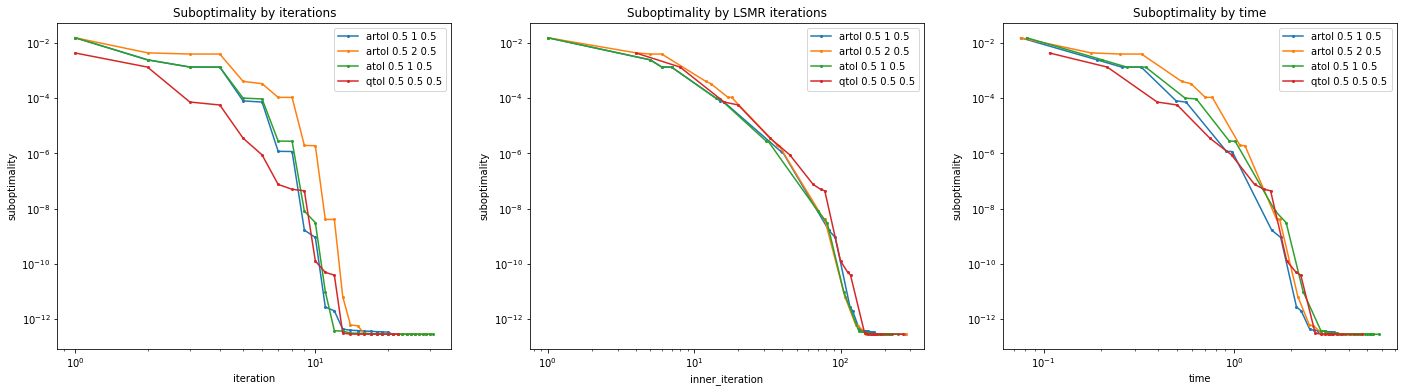

In [3]:
import matplotlib.pyplot as plt

results_filtered = results[results.stopping.isin(["atol 0.5 1 0.5", "artol 0.5 1 0.5", "artol 0.5 2 0.5", "qtol 0.5 0.5 0.5"])]

fig, axes = plt.subplots(ncols=3, figsize=(8*3, 6))
for label, group in results_filtered.groupby("stopping"):
    group.sort_values("iteration").plot(
        x="iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[0]
    )
    group.sort_values("iteration").plot(
        x="inner_iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[1]
    )
    group.sort_values("iteration").plot(
        x="time", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[2]
    )
axes[0].set_ylabel("suboptimality")
axes[0].set_title("Suboptimality by iterations")
axes[1].set_ylabel("suboptimality")
axes[1].set_title("Suboptimality by LSMR iterations")
axes[2].set_ylabel("suboptimality")
axes[2].set_title("Suboptimality by time")
plt.show()

### Multinomial Logistic Regression on freMTPL (Sparse)

In [1]:
%%time
import warnings
import numpy as np
from scipy import sparse
from sklearn._loss import HalfMultinomialLoss
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd
import matplotlib.pyplot as plt


def prepare_data():
    df = fetch_openml(data_id=41214, as_frame=True, parser='auto').frame
    df["Frequency"] = df["ClaimNb"] / df["Exposure"]
    log_scale_transformer = make_pipeline(
        FunctionTransformer(np.log, validate=False), StandardScaler()
    )
    linear_model_preprocessor = ColumnTransformer(
        [
            ("passthrough_numeric", "passthrough", ["BonusMalus"]),
            (
                "binned_numeric",
                KBinsDiscretizer(n_bins=10, subsample=None),
                ["VehAge", "DrivAge"],
            ),
            ("log_scaled_numeric", log_scale_transformer, ["Density"]),
            (
                "onehot_categorical",
                OneHotEncoder(),
                ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
            ),
        ],
        remainder="drop",
    )
    y = df["Frequency"]
    w = df["Exposure"]
    X = linear_model_preprocessor.fit_transform(df)
    return X, y, w


X, y_orig, w = prepare_data()

print("binning the target...")
binner = KBinsDiscretizer(
    n_bins=300, encode="ordinal", strategy="quantile", subsample=int(2e5), random_state=0
)
y = binner.fit_transform(y_orig.to_numpy().reshape(-1, 1)).ravel().astype(float)

# X = X.toarray()
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, train_size=10_000, test_size=10_000, random_state=0
)
print(f"{X_train.shape = }")
print(f"{sparse.issparse(X_train)=}")
n_classes = len(np.unique(y_train))
print(f"{n_classes=}")
# print("y_train.value_counts() :")
# print(pd.Series(y_train).value_counts())


results = []
slow_solvers = set()
loss_sw = np.full_like(y_train, fill_value=(1. / y_train.shape[0]))
alpha = 1e-12
solver = "newton-lsmr"
tol = 1e-10
for inner_stopping in [
    {"atol": (0.5, 0.5, 0.5, False)},
    {"atol": (0.5, 1, 0.5, False)},
    {"atol": (0.5, 1, 0.5, True)},
    {"atol": (0.5, 2, 0.5, False)},
    {"atol": (-1, None, None, False)},
    {"atol": (-1, None, None, True)},
    {"atol": (-2, None, None, False)},
    {"atol": (-2, None, None, True)},
    {"artol": (0.5, 0.5, 0.5, False)},
    {"artol": (0.5, 1, 0.5, False)},
    {"artol": (0.5, 1, 0.5, True)},
    {"artol": (0.5, 2, 0.5, False)},
    {"artol": (-1, None, None, False)},
    {"artol": (-1, None, None, True)},
    {"artol": (-2, None, None, False)},
    {"artol": (-2, None, None, True)},
    {"qtol": (0.5, 0.5, 0.5, False)},
    {"qtol": (0.5, 1, 0.5, False)},
    {"qtol": (0.5, 1, 0.5, True)},
    {"qtol": (0.5, 2, 0.5, False)},
    {"qtol": (-1, None, None, False)},
    {"qtol": (-1, None, None, True)},
    {"qtol": (-2, None, None, False)},
    {"qtol": (-2, None, None, True)},
    {"atol": (0.5, 1, 0.5, False), "artol": (0.5, 1, 0.5, False)},
]:
    inner_stopping_ratio = "+".join(inner_stopping.keys())
    k = list(inner_stopping.keys())[0]
    c0 = inner_stopping[k][0]
    c1 = inner_stopping[k][1]
    c2 = inner_stopping[k][2]
    track_loss = inner_stopping[k][3]
    tic = perf_counter()
    clf = LogisticRegression(
        C=1/alpha,
        solver=solver,
        tol=tol,
        max_iter=300,
        inner_stopping=inner_stopping,
    ).fit(X_train, y_train)
    toc = perf_counter()
    train_time = toc - tic
    n_iter = clf.n_iter_[0]
    # Look inside _GeneralizedLinearRegressor to check the parameters.
    # Or run once with verbose=1 and compare to the reported loss.
    train_loss = LinearModelLoss(
        base_loss=HalfMultinomialLoss(n_classes=n_classes), fit_intercept=clf.fit_intercept
    ).loss(
        coef=np.c_[clf.coef_, clf.intercept_],
        X=X_train,
        y=y_train,
        l2_reg_strength=alpha / X_train.shape[0],
        sample_weight=loss_sw,
    )
    result = {
        "tol": tol,
        "stopping_ratio": inner_stopping_ratio,
        "c0": c0,
        "c1": c1,
        "c2": c2,
        "track_loss": track_loss,
        "train_loss": train_loss,
        "train_time": train_time,
        "n_iter": n_iter,
        "report": clf.convergence_report[0],
        "converged": n_iter < clf.max_iter,
    }
    results.append(result)

results = pd.DataFrame.from_records([
    {
        "tol": level1_dict["tol"],
        "stopping_ratio": level1_dict["stopping_ratio"],
        "c0": level1_dict["c0"],
        "c1": level1_dict["c1"],
        "c2": level1_dict["c2"],
        "track_loss": level1_dict["track_loss"],
        "total_time": level1_dict["train_time"],
        "train_loss": level1_dict["train_loss"],
    } | convergence_report
    for level1_dict in results
    for convergence_report in level1_dict["report"]
])
results["suboptimality"] = results["loss"] - results["loss"].min() + 1e-16
results

binning the target...
X_train.shape = (10000, 75)
sparse.issparse(X_train)=True
n_classes=12


/Users/lorentzen/github/scikit-learn/sklearn/preprocessing/_discretization.py:312: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:308: ConvergenceWarning: Line search of Newton solver NewtonLSMRSolver at iteration #276 did no converge after 21 line search refinement iterations. It will now resort to lbfgs instead.
  warnings.warn(
/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:308: ConvergenceWarning: Line search of Newton solver NewtonLSMRSolver at iteration #104 did no converge after 21 line search refinement iterations. It will now resort to lbfgs instead.
  warnings.warn(
/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:492: ConvergenceWarning: Newton solver did not converge after 300 iterations.
  warnings.warn(
/Users/lorentzen/github/scikit

CPU times: user 30min 20s, sys: 9min 1s, total: 39min 21s
Wall time: 9min 56s


/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:308: ConvergenceWarning: Line search of Newton solver NewtonLSMRSolver at iteration #123 did no converge after 21 line search refinement iterations. It will now resort to lbfgs instead.
  warnings.warn(


,tol,stopping_ratio,c0,c1,c2,track_loss,total_time,train_loss,iteration,time,loss,fallback_lbfgs,inner_iteration,suboptimality
0,1.000000e-10,atol,0.5,0.5,0.5,False,22.932109,0.253253,1,0.022267,0.561326,False,1,3.080728e-01
1,1.000000e-10,atol,0.5,0.5,0.5,False,22.932109,0.253253,2,0.043898,0.357088,False,2,1.038349e-01
2,1.000000e-10,atol,0.5,0.5,0.5,False,22.932109,0.253253,3,0.124323,0.307820,False,23,5.456680e-02
3,1.000000e-10,atol,0.5,0.5,0.5,False,22.932109,0.253253,4,0.185048,0.290982,False,37,3.772866e-02
4,1.000000e-10,atol,0.5,0.5,0.5,False,22.932109,0.253253,5,0.200751,0.289238,False,38,3.598466e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,1.000000e-10,atol+artol,0.5,1.0,0.5,False,16.240161,0.253253,119,15.993107,0.253253,False,4097,8.439795e-08
5956,1.000000e-10,atol+artol,0.5,1.0,0.5,False,16.240161,0.253253,120,16.012034,0.253253,False,4099,8.439795e-08
5957,1.000000e-10,atol+artol,0.5,1.0,0.5,False,16.240161,0.253253,121,16.034592,0.253253,False,4102,8.439795e-08
5958,1.000000e-10,atol+artol,0.5,1.0,0.5,False,16.240161,0.253253,122,16.056918,0.253253,False,4105,8.439795e-08


In [2]:
# Check loss numbers match
tmp = results.query("stopping_ratio == 'atol' and c0 == 0.5 and c1 == 1 and c2 == 0.5 and track_loss == False and fallback_lbfgs == False").nlargest(1, "iteration")
(
    tmp.iloc[0]["train_loss"],
    tmp.iloc[0]["loss"]
)

(0.25325304855803665, 0.2532530485987265)

In [3]:
# minimum loss
results["loss"].min()

0.2532529799727292

In [4]:
# Which ones resorted to lbfgs?
results[results["fallback_lbfgs"] == True]

,tol,stopping_ratio,c0,c1,c2,track_loss,total_time,train_loss,iteration,time,loss,fallback_lbfgs,inner_iteration,suboptimality
275,1.000000e-10,atol,0.5,0.5,0.5,False,22.932109,0.253253,278,22.847294,0.253253,True,5485,1.019171e-08
379,1.000000e-10,atol,0.5,1.0,0.5,False,17.576285,0.253253,136,17.386707,0.253253,True,4135,6.862600e-08
1142,1.000000e-10,atol,-1.0,NaN,NaN,False,21.420539,0.253253,207,21.187007,0.253253,True,4845,5.256826e-08
1340,1.000000e-10,atol,-1.0,NaN,NaN,True,24.192216,0.253253,200,24.108230,0.253253,True,5140,3.773030e-09
2663,1.000000e-10,artol,0.5,1.0,0.5,True,18.718181,0.253253,183,18.461847,0.253253,True,4364,1.542859e-07
3087,1.000000e-10,artol,-1.0,NaN,NaN,False,19.382120,0.253253,135,19.277402,0.253253,True,4962,6.461737e-08
3159,1.000000e-10,artol,-1.0,NaN,NaN,True,19.268845,0.253253,79,19.177953,0.253253,True,5164,6.657926e-08
3268,1.000000e-10,artol,-2.0,NaN,NaN,False,28.221676,0.253253,111,28.139994,0.253253,True,7489,8.744929e-08
4038,1.000000e-10,qtol,0.5,1.0,0.5,False,19.683846,0.253253,176,19.589709,0.253253,True,4742,2.009157e-07
4636,1.000000e-10,qtol,0.5,2.0,0.5,False,28.074449,0.253253,300,27.997063,0.253253,True,6780,7.429920e-08


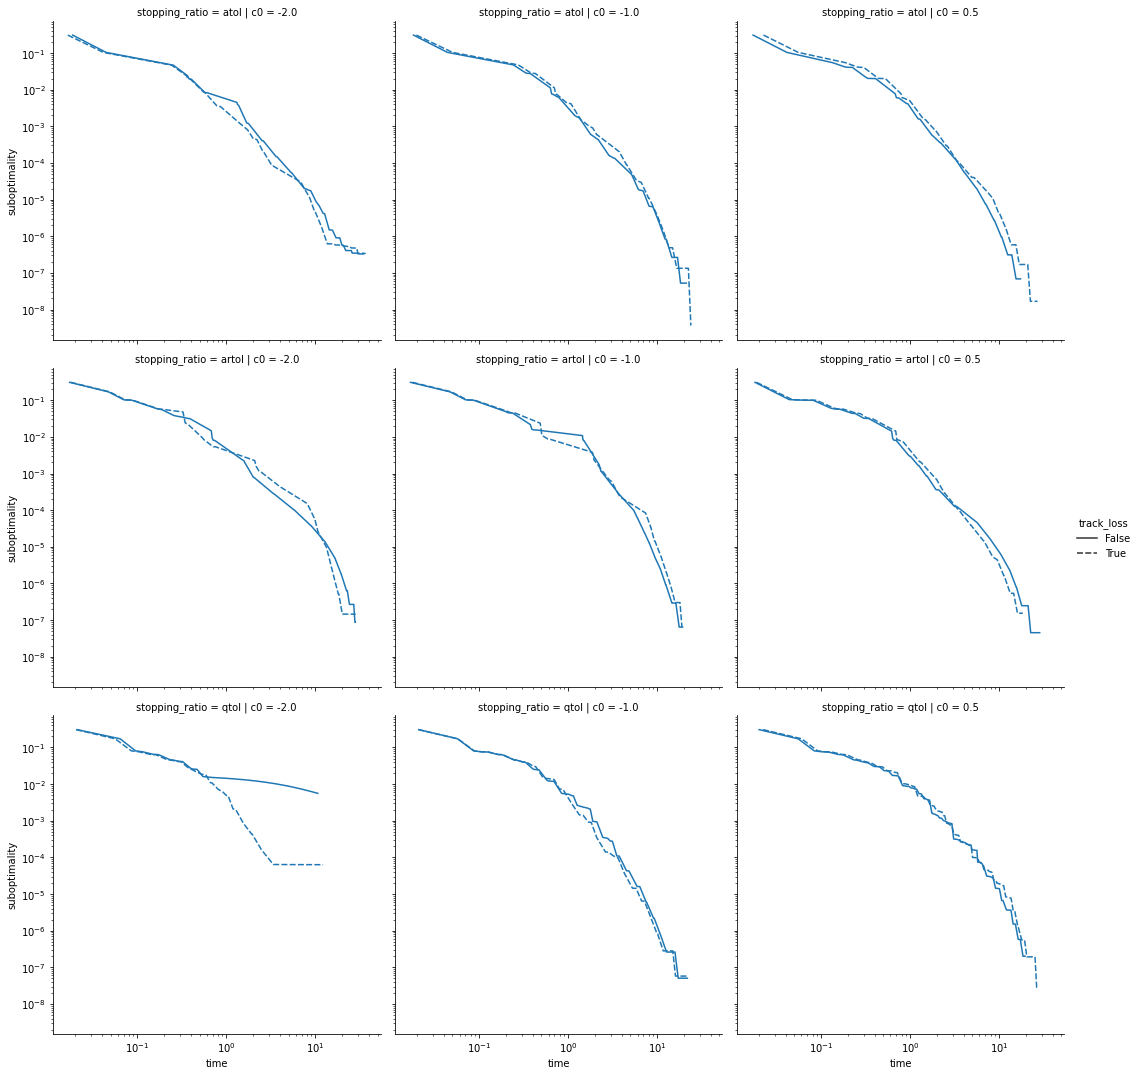

In [5]:
# With or without tracking loss improvement?
results_filtered = results[((results.c1 == 1) | results.c1.isnull()) & (results.stopping_ratio != "atol+artol")].copy()

import seaborn as sns

g = sns.relplot(
    data=results_filtered, x="time", y="suboptimality",
    row="stopping_ratio", col="c0", style="track_loss",
    kind="line"
)
g.set(xscale="log", yscale="log")

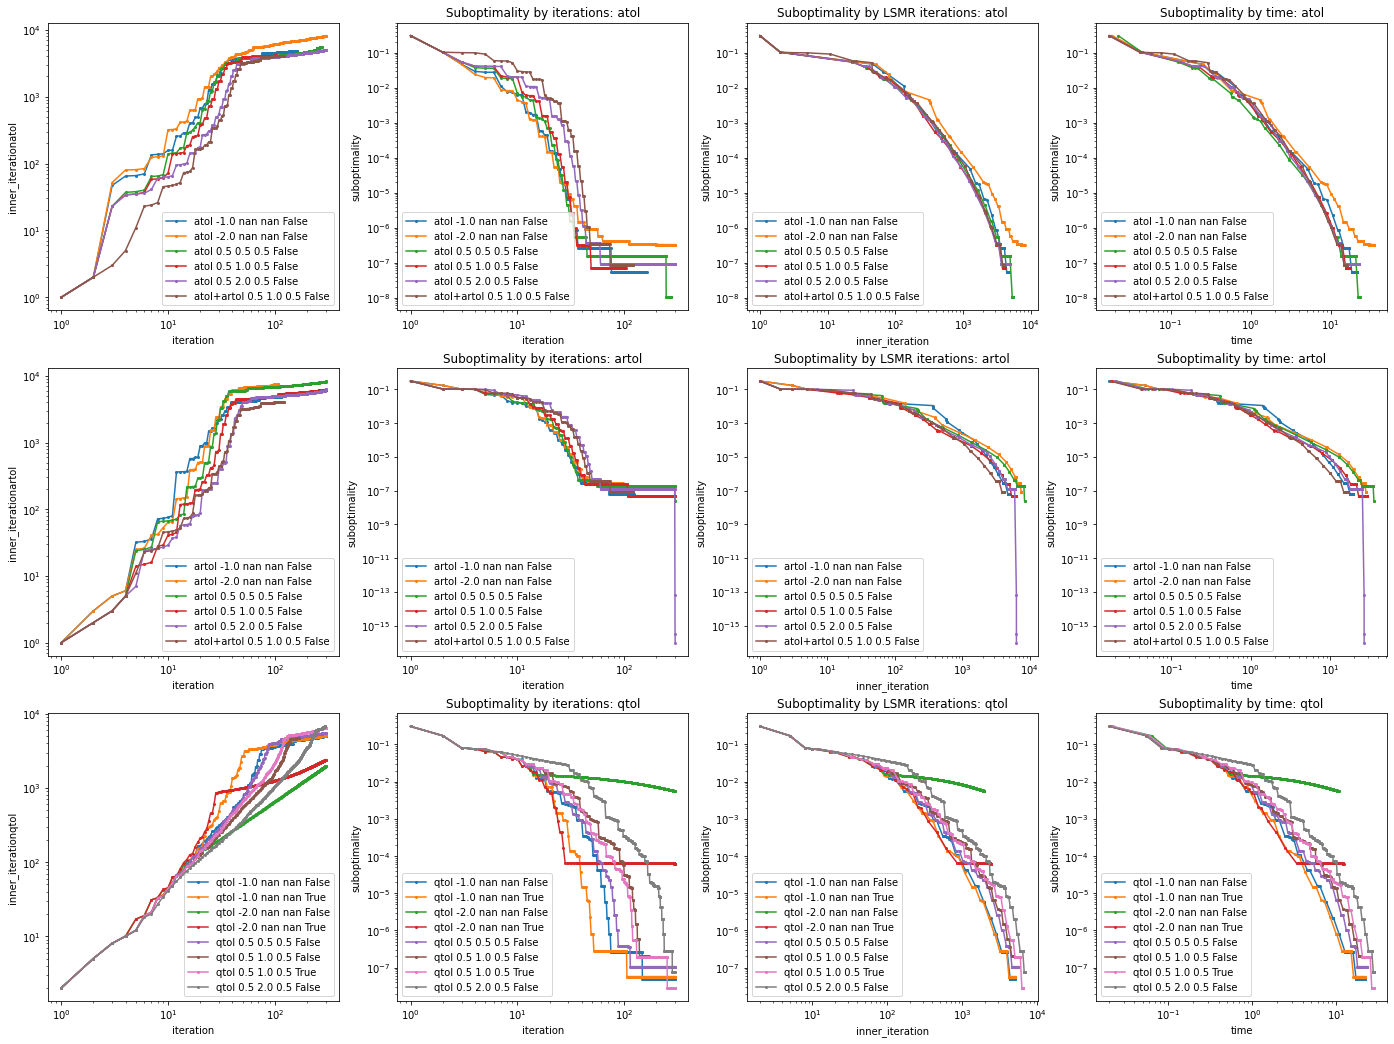

In [22]:
results_filtered = results[(results["fallback_lbfgs"] == False) & ((results.track_loss == False) | (results.stopping_ratio == "qtol"))].copy()
results_filtered["stopping"] = (
    results_filtered["stopping_ratio"]
    + " " + results_filtered["c0"].astype(str)
    + " " + results_filtered["c1"].astype(str)
    + " " + results_filtered["c2"].astype(str)
    + " " + results_filtered["track_loss"].astype(str)
)

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(8*3, 6*3))
for i, stop in enumerate(["atol", "artol", "qtol"]):
    for label, group in results_filtered[results_filtered.stopping.str.contains(stop)].groupby("stopping"):
        group.sort_values("iteration").plot(
            x="iteration", y="inner_iteration", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][0]
        )
        group.sort_values("iteration").plot(
            x="iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][1]
        )
        group.sort_values("iteration").plot(
            x="inner_iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][2]
        )
        group.sort_values("iteration").plot(
            x="time", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][3]
        )
    axes[i][0].set_ylabel("inner_iteration" + stop)
    for j in range(1, axes.shape[1]):
        axes[i][j].set_ylabel("suboptimality")
    axes[i][1].set_title("Suboptimality by iterations: " + stop)
    axes[i][2].set_title("Suboptimality by LSMR iterations: " + stop)
    axes[i][3].set_title("Suboptimality by time: " + stop)

plt.show()

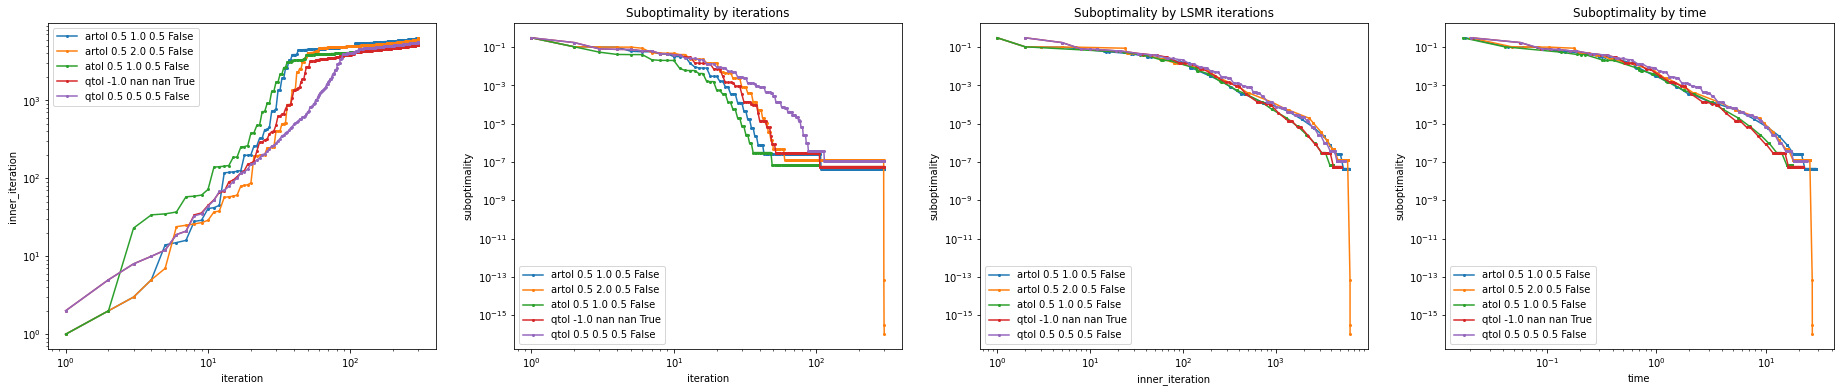

In [27]:
results_filtered = results[(results["fallback_lbfgs"] == False) & ((results.track_loss == False) | (results.stopping_ratio == "qtol"))].copy()
results_filtered["stopping"] = (
    results_filtered["stopping_ratio"]
    + " " + results_filtered["c0"].astype(str)
    + " " + results_filtered["c1"].astype(str)
    + " " + results_filtered["c2"].astype(str)
    + " " + results_filtered["track_loss"].astype(str)
)
results_filtered = results_filtered[results_filtered.stopping.isin([
    "atol 0.5 1.0 0.5 False",
    "artol 0.5 1.0 0.5 False",
    "artol 0.5 2.0 0.5 False",
    "qtol 0.5 0.5 0.5 False",
    "qtol -1.0 nan nan True",
])]

fig, axes = plt.subplots(ncols=4, figsize=(8*4, 6))
for label, group in results_filtered.groupby("stopping"):
    group.sort_values("iteration").plot(
            x="iteration", y="inner_iteration", loglog=True, marker="o", markersize=2, label=label, ax=axes[0]
        )
    group.sort_values("iteration").plot(
        x="iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[1]
    )
    group.sort_values("iteration").plot(
        x="inner_iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[2]
    )
    group.sort_values("iteration").plot(
        x="time", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[3]
    )
axes[0].set_ylabel("inner_iteration")
for i in range(1, axes.shape[0]):
    axes[i].set_ylabel("suboptimality")
axes[1].set_title("Suboptimality by iterations")
axes[2].set_title("Suboptimality by LSMR iterations")
axes[3].set_title("Suboptimality by time")
plt.show()

In [14]:
with pd.option_context('display.float_format',  '{:,.10e}'.format):
    display(results.query("stopping == 'atol 0.5 1 0.5' and iteration == 100"))

,tol,stopping,total_time,train_loss,iteration,time,loss,inner_iteration,suboptimality
374,1.0000000000e-10,atol 0.5 1 0.5,1.6083633383e+01,2.5325304856e-01,100,1.5826548548e+01,2.5325304860e-01,4118,6.8626029792e-08


In [30]:
alpha=1e-12
clf = LogisticRegression(
    C=1/alpha,
    solver=solver,
    tol=1e-10,
    max_iter=50,
    inner_stopping={"qtol": (-1, None, None, False)},
    verbose=3,
).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
    norm(gradient)=53.91594959790576 eta=0.5
    A_norm=1 r_norm=1 Ar_norm=1 atol=0
  Inner iterations in LSMR = 2, total = 2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -1.9247974594495898 <= -0.004564050282284683 True
  Check Convergence
    loss = 0.5601091903384107.
    1. max |gradient| 3.146579789937196 <= 1e-10
Newton iter=2
    norm(gradient)=3.362786060355206 eta=0.0609084983200039
    A_norm=17.848207082755636 r_norm=1.241403723909487 Ar_norm=0.07884653484974849 atol=0
  Inner iterations in LSMR = 3, total = 5
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: 335.52416345790846 <= -0.004459829827021559 False
      check loss |improvement| <= eps * |loss_old|: 335.52416345790846 <= 1.989907582137145e-15 False
    line search iteration=2, step si

/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:492: ConvergenceWarning: Newton solver did not converge after 50 iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


In [31]:
alpha=1e-12
clf = LogisticRegression(
    C=1/alpha,
    solver=solver,
    tol=1e-10,
    max_iter=50,
    inner_stopping={"qtol": (-1, None, None, True)},
    verbose=3,
).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
    norm(gradient)=53.91594959790576 eta=0.5
    A_norm=1 r_norm=1 Ar_norm=1 atol=0
  Inner iterations in LSMR = 2, total = 2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -1.9247974594495898 <= -0.004564050282284683 True
  Check Convergence
    loss = 0.5601091903384107.
    1. max |gradient| 3.146579789937196 <= 1e-10
Newton iter=2
    norm(gradient)=3.362786060355206 eta=0.0609084983200039
    A_norm=17.848207082755636 r_norm=1.241403723909487 Ar_norm=0.07884653484974849 atol=0
  Inner iterations in LSMR = 3, total = 5
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: 335.52416345790846 <= -0.004459829827021559 False
      check loss |improvement| <= eps * |loss_old|: 335.52416345790846 <= 1.989907582137145e-15 False
    line search iteration=2, step si

/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:492: ConvergenceWarning: Newton solver did not converge after 50 iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s finished


### 20 newsgroup unpenalized

In [1]:
%%time
from pathlib import Path
import numpy as np
from scipy import sparse
from sklearn._loss import HalfMultinomialLoss
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd
import matplotlib.pyplot as plt


X, y = fetch_20newsgroups_vectorized(subset="all", return_X_y=True)
y = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.5, test_size=0.5, random_state=0
)
print(f"{X_train.shape = }")
print(f"{sparse.issparse(X_train)=}")
n_classes = len(np.unique(y_train))
print(f"{n_classes=}")
#print("y_train.value_counts() :")
#print(pd.Series(y_train).value_counts())


results = []
slow_solvers = set()
loss_sw = np.full_like(y_train, fill_value=(1. / y_train.shape[0]))
alpha = 1e-12
solver = "newton-lsmr"
tol = 1e-10
for inner_stopping in [
    #{"atol": (0.5, 0.5, 0.5, False)},
    {"atol": (0.5, 1, 0.5, False)},
    {"atol": (0.5, 1, 0.5, True)},
    #{"atol": (0.5, 2, 0.5, False)},
    {"atol": (-1, None, None, False)},
    {"atol": (-1, None, None, True)},
    {"atol": (-2, None, None, False)},
    {"atol": (-2, None, None, True)},
    #{"artol": (0.5, 0.5, 0.5, False)},
    {"artol": (0.5, 1, 0.5, False)},
    {"artol": (0.5, 1, 0.5, True)},
    {"artol": (0.5, 2, 0.5, False)},
    {"artol": (-1, None, None, False)},
    {"artol": (-1, None, None, True)},
    {"artol": (-2, None, None, False)},
    {"artol": (-2, None, None, True)},
    #{"qtol": (0.5, 0.5, 0.5, False)},
    {"qtol": (0.5, 1, 0.5, False)},
    {"qtol": (0.5, 1, 0.5, True)},
    #{"qtol": (0.5, 2, 0.5, False)},
    {"qtol": (-1, None, None, False)},
    {"qtol": (-1, None, None, True)},
    {"qtol": (-2, None, None, False)},
    {"qtol": (-2, None, None, True)},
    {"atol": (0.5, 1, 0.5, False), "artol": (0.5, 1, 0.5, False)},
]:
    inner_stopping_ratio = "+".join(inner_stopping.keys())
    k = list(inner_stopping.keys())[0]
    c0 = inner_stopping[k][0]
    c1 = inner_stopping[k][1]
    c2 = inner_stopping[k][2]
    track_loss = inner_stopping[k][3]
    tic = perf_counter()
    clf = LogisticRegression(
        C=1/alpha,
        solver=solver,
        tol=tol,
        max_iter=20,
        inner_stopping=inner_stopping,
    ).fit(X_train, y_train)
    toc = perf_counter()
    train_time = toc - tic
    n_iter = clf.n_iter_[0]
    # Look inside _GeneralizedLinearRegressor to check the parameters.
    # Or run once with verbose=1 and compare to the reported loss.
    train_loss = LinearModelLoss(
        base_loss=HalfMultinomialLoss(n_classes=n_classes), fit_intercept=clf.fit_intercept
    ).loss(
        coef=np.c_[clf.coef_, clf.intercept_],
        X=X_train,
        y=y_train,
        l2_reg_strength=alpha / X_train.shape[0],
        sample_weight=loss_sw,
    )
    result = {
        "tol": tol,
        "stopping_ratio": inner_stopping_ratio,
        "c0": c0,
        "c1": c1,
        "c2": c2,
        "track_loss": track_loss,
        "train_loss": train_loss,
        "train_time": train_time,
        "n_iter": n_iter,
        "report": clf.convergence_report[0],
        "converged": n_iter < clf.max_iter,
    }
    results.append(result)

# Get the "true" loss
# Here we know that it is zero, otherwise we could use lbfgs
train_loss = 0

results = pd.DataFrame.from_records([
    {
        "tol": level1_dict["tol"],
        "stopping_ratio": level1_dict["stopping_ratio"],
        "c0": level1_dict["c0"],
        "c1": level1_dict["c1"],
        "c2": level1_dict["c2"],
        "track_loss": level1_dict["track_loss"],
        "total_time": level1_dict["train_time"],
        "train_loss": level1_dict["train_loss"],
    } | convergence_report
    for level1_dict in results
    for convergence_report in level1_dict["report"]
])
results["suboptimality"] = results["loss"] - train_loss + 1e-16

filepath = Path().resolve() / "bench_multinomial_logistic_regression_20newsgroup_stopping_criterion.csv"
results.to_csv(filepath)

results

X_train.shape = (9423, 130107)
sparse.issparse(X_train)=True
n_classes=20


/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:492: ConvergenceWarning: Newton solver did not converge after 20 iterations.
  warnings.warn(
/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:492: ConvergenceWarning: Newton solver did not converge after 20 iterations.
  warnings.warn(
/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:492: ConvergenceWarning: Newton solver did not converge after 20 iterations.
  warnings.warn(
/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:492: ConvergenceWarning: Newton solver did not converge after 20 iterations.
  warnings.warn(
/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:492: ConvergenceWarning: Newton solver did not converge after 20 iterations.
  warnings.warn(
/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:492: ConvergenceWarning: Newton solver did n

CPU times: user 4h 36min 23s, sys: 1h 37min 3s, total: 6h 13min 26s
Wall time: 1h 35min 32s


/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/_newton_solver.py:492: ConvergenceWarning: Newton solver did not converge after 20 iterations.
  warnings.warn(


,tol,stopping_ratio,c0,c1,c2,track_loss,total_time,train_loss,iteration,time,loss,fallback_lbfgs,inner_iteration,suboptimality
0,1.000000e-10,atol,0.5,1.0,0.5,False,776.786444,5.858407e-10,1,25.415763,1.272764e-05,False,163,1.272764e-05
1,1.000000e-10,atol,0.5,1.0,0.5,False,776.786444,5.858407e-10,2,195.372068,4.447785e-06,False,1258,4.447785e-06
2,1.000000e-10,atol,0.5,1.0,0.5,False,776.786444,5.858407e-10,3,197.529174,1.623124e-06,False,1265,1.623124e-06
3,1.000000e-10,atol,0.5,1.0,0.5,False,776.786444,5.858407e-10,4,200.138937,6.045958e-07,False,1277,6.045958e-07
4,1.000000e-10,atol,0.5,1.0,0.5,False,776.786444,5.858407e-10,5,206.100920,2.248941e-07,False,1312,2.248941e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,1.000000e-10,atol+artol,0.5,1.0,0.5,False,645.703791,1.457920e-08,16,224.225965,7.842247e-07,False,1594,7.842247e-07
350,1.000000e-10,atol+artol,0.5,1.0,0.5,False,645.703791,1.457920e-08,17,290.668519,2.886939e-07,False,2075,2.886939e-07
351,1.000000e-10,atol+artol,0.5,1.0,0.5,False,645.703791,1.457920e-08,18,378.988517,1.063379e-07,False,2714,1.063379e-07
352,1.000000e-10,atol+artol,0.5,1.0,0.5,False,645.703791,1.457920e-08,19,494.267700,3.924951e-08,False,3558,3.924951e-08


In [8]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


filepath = Path().resolve() / "bench_multinomial_logistic_regression_20newsgroup_stopping_criterion.csv"
results = pd.read_csv(filepath)
results

,Unnamed: 0,tol,stopping_ratio,c0,c1,c2,track_loss,total_time,train_loss,iteration,time,loss,fallback_lbfgs,inner_iteration,suboptimality
0,0,1.000000e-10,atol,0.5,1.0,0.5,False,776.786444,5.858407e-10,1,25.415763,1.272764e-05,False,163,1.272764e-05
1,1,1.000000e-10,atol,0.5,1.0,0.5,False,776.786444,5.858407e-10,2,195.372068,4.447785e-06,False,1258,4.447785e-06
2,2,1.000000e-10,atol,0.5,1.0,0.5,False,776.786444,5.858407e-10,3,197.529174,1.623124e-06,False,1265,1.623124e-06
3,3,1.000000e-10,atol,0.5,1.0,0.5,False,776.786444,5.858407e-10,4,200.138937,6.045958e-07,False,1277,6.045958e-07
4,4,1.000000e-10,atol,0.5,1.0,0.5,False,776.786444,5.858407e-10,5,206.100920,2.248941e-07,False,1312,2.248941e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,349,1.000000e-10,atol+artol,0.5,1.0,0.5,False,645.703791,1.457920e-08,16,224.225965,7.842247e-07,False,1594,7.842247e-07
350,350,1.000000e-10,atol+artol,0.5,1.0,0.5,False,645.703791,1.457920e-08,17,290.668519,2.886939e-07,False,2075,2.886939e-07
351,351,1.000000e-10,atol+artol,0.5,1.0,0.5,False,645.703791,1.457920e-08,18,378.988517,1.063379e-07,False,2714,1.063379e-07
352,352,1.000000e-10,atol+artol,0.5,1.0,0.5,False,645.703791,1.457920e-08,19,494.267700,3.924951e-08,False,3558,3.924951e-08


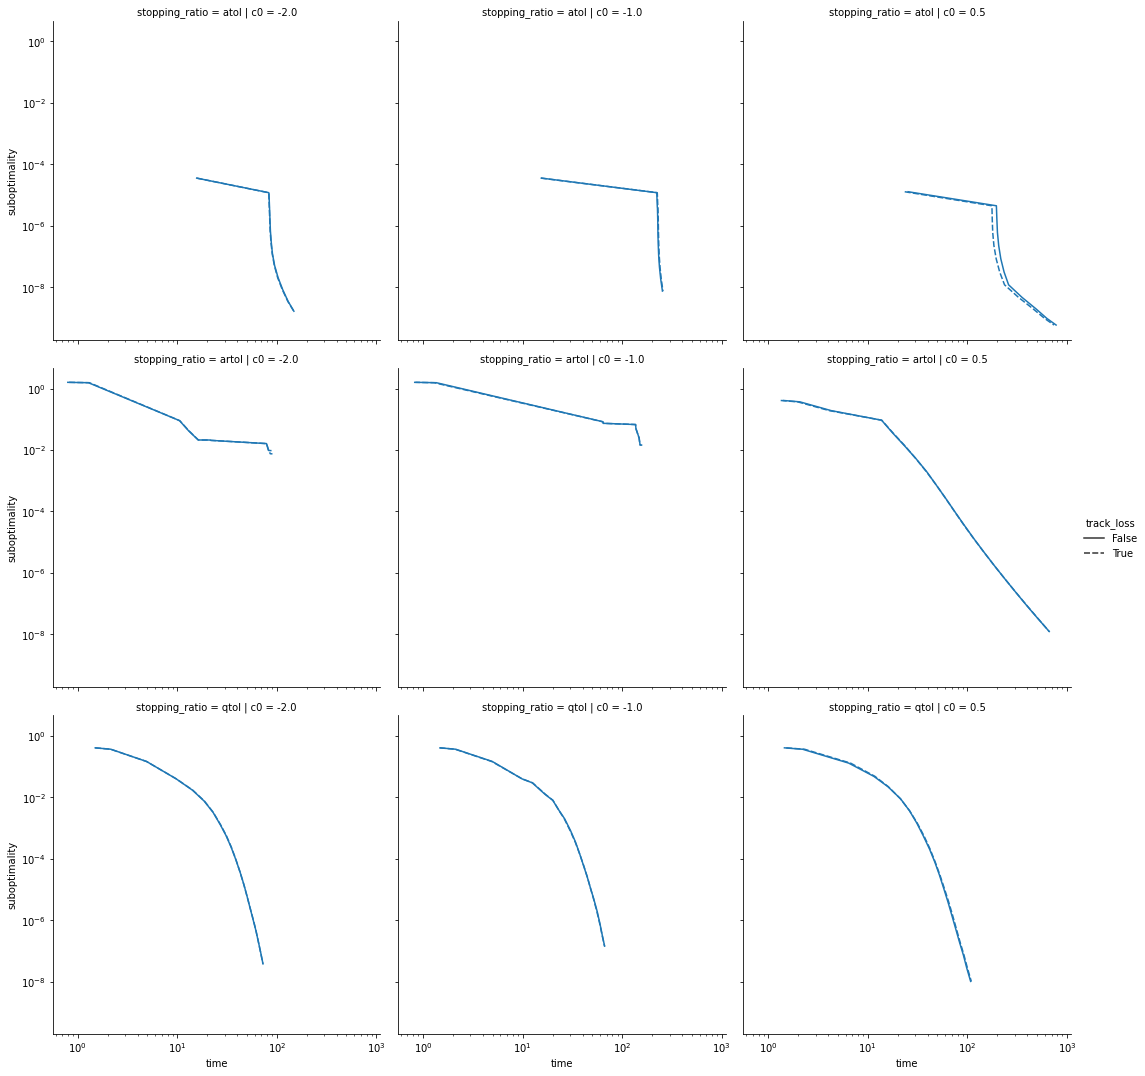

In [2]:
# With or without tracking loss improvement?
results_filtered = results[((results.c1 == 1) | results.c1.isnull()) & (results.stopping_ratio != "atol+artol")].copy()

import seaborn as sns

g = sns.relplot(
    data=results_filtered, x="time", y="suboptimality",
    row="stopping_ratio", col="c0", style="track_loss",
    kind="line"
)
g.set(xscale="log", yscale="log")

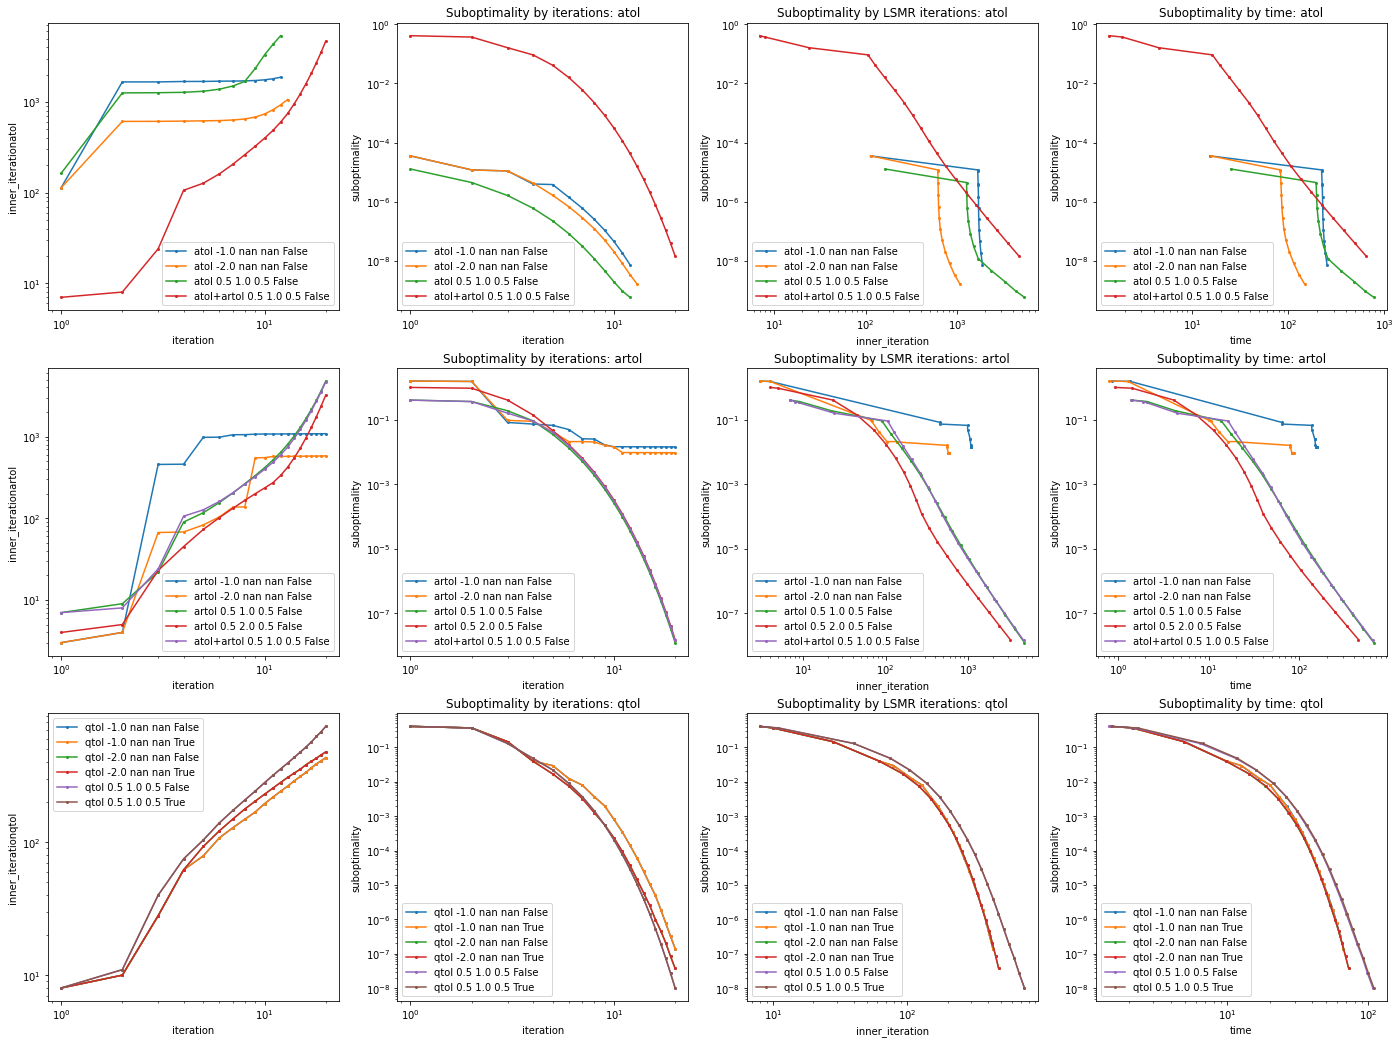

In [4]:
results_filtered = results[(results["fallback_lbfgs"] == False) & ((results.track_loss == False) | (results.stopping_ratio == "qtol"))].copy()
results_filtered["stopping"] = (
    results_filtered["stopping_ratio"]
    + " " + results_filtered["c0"].astype(str)
    + " " + results_filtered["c1"].astype(str)
    + " " + results_filtered["c2"].astype(str)
    + " " + results_filtered["track_loss"].astype(str)
)

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(8*3, 6*3))
for i, stop in enumerate(["atol", "artol", "qtol"]):
    for label, group in results_filtered[results_filtered.stopping.str.contains(stop)].groupby("stopping"):
        group.sort_values("iteration").plot(
            x="iteration", y="inner_iteration", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][0]
        )
        group.sort_values("iteration").plot(
            x="iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][1]
        )
        group.sort_values("iteration").plot(
            x="inner_iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][2]
        )
        group.sort_values("iteration").plot(
            x="time", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[i][3]
        )
    axes[i][0].set_ylabel("inner_iteration" + stop)
    for j in range(1, axes.shape[1]):
        axes[i][j].set_ylabel("suboptimality")
    axes[i][1].set_title("Suboptimality by iterations: " + stop)
    axes[i][2].set_title("Suboptimality by LSMR iterations: " + stop)
    axes[i][3].set_title("Suboptimality by time: " + stop)

plt.show()

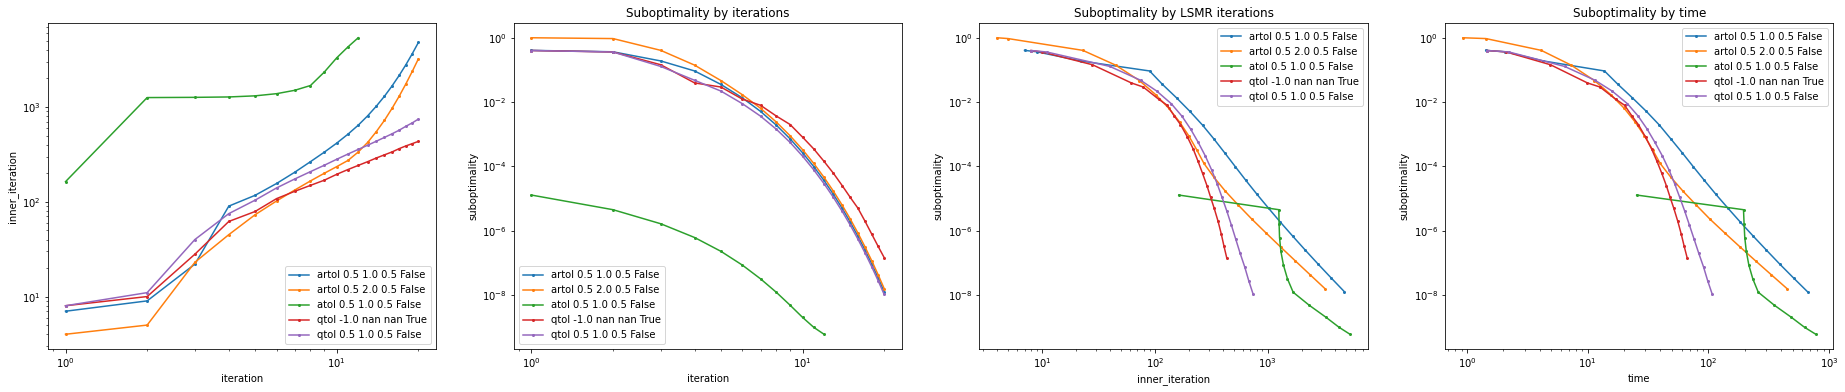

In [6]:
results_filtered = results[(results["fallback_lbfgs"] == False) & ((results.track_loss == False) | (results.stopping_ratio == "qtol"))].copy()
results_filtered["stopping"] = (
    results_filtered["stopping_ratio"]
    + " " + results_filtered["c0"].astype(str)
    + " " + results_filtered["c1"].astype(str)
    + " " + results_filtered["c2"].astype(str)
    + " " + results_filtered["track_loss"].astype(str)
)
results_filtered = results_filtered[results_filtered.stopping.isin([
    "atol 0.5 1.0 0.5 False",
    "artol 0.5 1.0 0.5 False",
    "artol 0.5 2.0 0.5 False",
    "qtol 0.5 1.0 0.5 False",
    "qtol -1.0 nan nan True",
])]

fig, axes = plt.subplots(ncols=4, figsize=(8*4, 6))
for label, group in results_filtered.groupby("stopping"):
    group.sort_values("iteration").plot(
            x="iteration", y="inner_iteration", loglog=True, marker="o", markersize=2, label=label, ax=axes[0]
        )
    group.sort_values("iteration").plot(
        x="iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[1]
    )
    group.sort_values("iteration").plot(
        x="inner_iteration", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[2]
    )
    group.sort_values("iteration").plot(
        x="time", y="suboptimality", loglog=True, marker="o", markersize=2, label=label, ax=axes[3]
    )
axes[0].set_ylabel("inner_iteration")
for i in range(1, axes.shape[0]):
    axes[i].set_ylabel("suboptimality")
axes[1].set_title("Suboptimality by iterations")
axes[2].set_title("Suboptimality by LSMR iterations")
axes[3].set_title("Suboptimality by time")
plt.show()

In [3]:
clf = LogisticRegression(
    C=1/1e-12,
    solver="newton-lsmr",
    tol=1e-10,
    max_iter=20,
    inner_stopping={"atol": (0.5, 1, 0.5, False)},
    verbose=3,
).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
    norm(gradient)=4.1979e-02 eta=2.0489e-01
    A_norm=2.9912e+02 r_norm=1.0000e+00 Ar_norm=1.0000e+00 atol=2.8754e-05
    b_norm=4.3589e+00 btol=1.0000e-10
  Inner iterations in LSMR = 163, total = 163, istop = 1 normx = 3.254e+03
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -2.995719545916458 <= -0.009260970458388548 True
  Check Convergence
    loss = 1.2727637533002378e-05.
    1. max |gradient| 6.2594917575024265e-06 <= 1e-10
Newton iter=2
    norm(gradient)=1.2483e-05 eta=3.5331e-03
    A_norm=1.4081e+00 r_norm=1.2737e-01 Ar_norm=3.1593e-05 atol=2.4590e-07
    b_norm=3.6335e-03 btol=1.0000e-10
  Inner iterations in LSMR = 1095, total = 1258, istop = 2 normx = 1.320e+02
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -8.27985289557723e-06 <= -6.44

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.6min finished


In [4]:
clf.convergence_report

array([[{'iteration': 1, 'time': 34.801784033000004, 'loss': 1.2727637533002378e-05, 'fallback_lbfgs': False, 'inner_iteration': 163},
        {'iteration': 2, 'time': 244.890482442, 'loss': 4.44778463742515e-06, 'fallback_lbfgs': False, 'inner_iteration': 1258},
        {'iteration': 3, 'time': 246.57131942800004, 'loss': 1.6231242442116378e-06, 'fallback_lbfgs': False, 'inner_iteration': 1265},
        {'iteration': 4, 'time': 249.19842278800002, 'loss': 6.045957507914208e-07, 'fallback_lbfgs': False, 'inner_iteration': 1277},
        {'iteration': 5, 'time': 255.73107937400005, 'loss': 2.248940521262628e-07, 'fallback_lbfgs': False, 'inner_iteration': 1312},
        {'iteration': 6, 'time': 268.5917434830001, 'loss': 8.354516695340428e-08, 'fallback_lbfgs': False, 'inner_iteration': 1383},
        {'iteration': 7, 'time': 289.20687950600006, 'loss': 3.122796440280297e-08, 'fallback_lbfgs': False, 'inner_iteration': 1501},
        {'iteration': 8, 'time': 321.47332255300006, 'loss': 

In [5]:
np.linalg.norm(clf.coef_)

2559.567627543248

In [3]:
# safegard too aprupt changes of atol, A_norm regularization 1e-12 instead of 1e-6.
clf = LogisticRegression(
    C=1/1e-12,
    solver="newton-lsmr",
    tol=1e-10,
    max_iter=20,
    inner_stopping={"atol": (0.5, 1, 0.5, False)},
    verbose=3,
).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Newton iter=1
    norm(gradient)=4.198e-02 eta=2.049e-01
    A_norm=2.991e+02 r_norm=1.000e+00 Ar_norm=1.000e+00 atol=2.875e-05
    b_norm=4.359e+00 btol=1.000e-10
  Inner iterations in LSMR = 163, total = 163, istop = 1 normx = 3.254e+03
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -2.995719545916458 <= -0.009260970458388548 True
  Check Convergence
    loss = 1.2727637533002378e-05.
    1. max |gradient| 6.2594917575024265e-06 <= 1e-10
Newton iter=2
    norm(gradient)=1.248e-05 eta=3.533e-03
    A_norm=1.408e+00 r_norm=1.274e-01 Ar_norm=3.159e-05 atol=8.409e-07
    b_norm=3.634e-03 btol=1.000e-10
  Inner iterations in LSMR = 659, total = 822, istop = 2 normx = 1.130e+02
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -8.279778749443078e-06 <= -6.445836972254929e-09

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.8min finished


In [4]:
clf.convergence_report

array([[{'iteration': 1, 'time': 49.609410921000006, 'loss': 1.2727637533002378e-05, 'fallback_lbfgs': False, 'inner_iteration': 163},
        {'iteration': 2, 'time': 232.66971299199997, 'loss': 4.4478587835592996e-06, 'fallback_lbfgs': False, 'inner_iteration': 822},
        {'iteration': 3, 'time': 234.98126533599998, 'loss': 1.6281669984467293e-06, 'fallback_lbfgs': False, 'inner_iteration': 828},
        {'iteration': 4, 'time': 237.96868322899996, 'loss': 6.086943074379564e-07, 'fallback_lbfgs': False, 'inner_iteration': 836},
        {'iteration': 5, 'time': 244.301317762, 'loss': 2.2951958162460251e-07, 'fallback_lbfgs': False, 'inner_iteration': 857},
        {'iteration': 6, 'time': 254.78668675, 'loss': 8.629130620416836e-08, 'fallback_lbfgs': False, 'inner_iteration': 895},
        {'iteration': 7, 'time': 269.651689834, 'loss': 3.258084448972161e-08, 'fallback_lbfgs': False, 'inner_iteration': 952},
        {'iteration': 8, 'time': 290.432977038, 'loss': 1.2504659735610402